# Package Installation

In [ ]:
!pip install propy3
!pip install modlamp
!pip install Bio
!pip install tree
!pip install torch
!pip install sigopt
!pip install --upgrade blosum

import numpy as np
import scipy as sp
import math
import subprocess
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import random
import pickle
import csv

from modlamp.descriptors import GlobalDescriptor
from modlamp.sequences import Helices

from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

import sigopt
from sigopt import Connection

from propy import PyPro
from propy import PseudoAAC
from propy import AAComposition
from propy import Autocorrelation
from propy import CTD
from propy import QuasiSequenceOrder

from multiprocessing import Pool, cpu_count

from Bio import pairwise2
from Bio.Align import substitution_matrices

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.3/290.3 kB 15.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 76.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.2/345.2 kB 35.6 MB/s eta 0:00:00
  Created wheel for modlamp: filename=modlamp-4.3.0-py3-none-any.whl size=173892 sha256=095221575b676982db2dc7e7d9d4b403a15b8f8e8bab9543af10234b48ca5779
  Stored in directory: /root/.cache/pip/wheels/9f/7a/a7/0cefab553c72735684a2b7fe2a70334894c44710fb333e37ee
Successfully built modlamp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# Color Palettes & Plot Structure

In [ ]:
# via Albert Tian Chen (https://atchen.me/research/code/data-viz/2022/01/04/plotting-matplotlib-reference.html#:~:text=For%20figures%2C%20I%20go%20with,down%20to%207%20pt%20font.)

_new_black = '#373737'
sns.set_theme(style='ticks', font_scale=0.75, rc={
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'axes.labelpad': 2,
    'axes.linewidth': 0.5,
    'axes.titlepad': 4,
    'lines.linewidth': 0.5,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'xtick.major.size': 2,
    'xtick.major.pad': 1,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'ytick.major.pad': 1,
    'ytick.major.width': 0.5,
    'xtick.minor.size': 2,
    'xtick.minor.pad': 1,
    'xtick.minor.width': 0.5,
    'ytick.minor.size': 2,
    'ytick.minor.pad': 1,
    'ytick.minor.width': 0.5,

    # Avoid black unless necessary
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False, # Seaborn turns on edgecolors for histograms by default and I don't like it
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    # 'axes.titlecolor': _new_black # should fallback to text.color
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black

    # Default colormap - personal preference
    # 'image.cmap': 'inferno'
})

def tol_cset(colorset=None):
    """
    Discrete color sets for qualitative data.

    Define a namedtuple instance with the colors.
    Examples for: cset = tol_cset(<scheme>)
      - cset.red and cset[1] give the same color (in default 'bright' colorset)
      - cset._fields gives a tuple with all color names
      - list(cset) gives a list with all colors
    """
    from collections import namedtuple
    
    namelist = ('bright', 'prism', 'high-contrast', 'vibrant', 'muted', 'medium-contrast', 'light')
    if colorset == None:
        return namelist
    if colorset not in namelist:
        colorset = 'bright'
        print('*** Warning: requested colorset not defined,',
              'known colorsets are {}.'.format(namelist),
              'Using {}.'.format(colorset)) 

    if colorset == 'prism':
        cset = namedtuple('Pcset',
                    'black1 black2 pink1 pink2 green1 green2 violet1 violet2 purple1 purple2 blue1 blue2')
        return cset('#000100', '#7f7f7f', '#ff2d78', '#ff9dbc', '#019092', '#94c7c9', 
                    '#531b92', '#aa8fc9', '#ba82ff', '#ddc1ff', '75d5fe', 'bcebff')
        
    if colorset == 'bright':
        cset = namedtuple('Bcset',
                    'blue red green yellow cyan purple grey black')
        return cset('#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE',
                    '#AA3377', '#BBBBBB', '#000000')

    if colorset == 'high-contrast':
        cset = namedtuple('Hcset',
                    'blue yellow red black')
        return cset('#004488', '#DDAA33', '#BB5566', '#000000')

    if colorset == 'vibrant':
        cset = namedtuple('Vcset',
                    'orange blue cyan magenta red teal grey black')
        return cset('#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311',
                    '#009988', '#BBBBBB', '#000000')

    if colorset == 'muted':
        cset = namedtuple('Mcset',
                    'rose indigo sand green cyan wine teal olive purple pale_grey black')
        return cset('#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
                    '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
                    '#000000')

    if colorset == 'medium-contrast':
        cset = namedtuple('Mcset',
                    'light_blue dark_blue light_yellow dark_red dark_yellow light_red black')
        return cset('#6699CC', '#004488', '#EECC66', '#994455', '#997700',
                    '#EE99AA', '#000000')

    if colorset == 'light':
        cset = namedtuple('Lcset',
                    'light_blue orange light_yellow pink light_cyan mint pear olive pale_grey black')
        return cset('#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF',
                    '#44BB99', '#BBCC33', '#AAAA00', '#DDDDDD', '#000000')

# Featurization

In [ ]:
import numpy as np

def cf_helicity(my_sequence):
    # Define the Chou-Fasman parameters
    alpha_helix_params = {
        'A': [142,  83,  66, 106, 130,  84, 116,  54,  78,  60],
        'C': [ 99, 119, 119, 167, 153,  96, 121,  56, 119,  18],
        'D': [101,  47,  57,  75, 163,  84,  97, 163,  37,  59],
        'E': [151,  25,  37,  56, 194,  84,  74, 194,  37,  49],
        'F': [113, 138, 138, 187, 135, 114, 137,  58, 113,  13],
        'G': [ 57,  75,  75,  75,  75,  57,  75,  37,  60,  60],
        'H': [ 83,  66,  83,  96, 167,  73, 105,  26,  83,  20],
        'I': [108, 160, 160, 151, 131,  97, 131,  43, 108,  15],
        'K': [121,  54,  57,  87, 159,  60, 117, 159,  31,  56],
        'L': [121, 130, 130, 151, 131,  97, 131,  43, 108,  13],
        'M': [137, 105, 105, 137, 170, 114, 137,  15, 137,   8],
        'N': [ 81,  47,  47,  60, 163,  60,  75, 163,  31,  47],
        'P': [ 57,  75,  75,  75,  75,  57,  75,  37,  60,  60],
        'Q': [111,  36,  47,  56, 180,  84,  87, 180,  31,  42],
        'R': [114,  54,  57,  75, 141,  60, 105, 141,  31,  56],
        'S': [ 77,  60,  54,  54, 120,  54,  60, 120,  26,  42],
        'T': [ 83,  97,  83,  83, 102,  97,  83,  56,  83,  31],
        'V': [ 99, 170, 170, 142, 105,  73, 105,  26,  99,  13],
        'W': [108, 137, 137, 186, 108, 114, 167,  35, 108,  10],
        'Y': [ 83, 138, 138, 173,  99,  84, 147,  47,  83,  12]
    }

    #Define the input sequence
    sequence = my_sequence

    #Initialize the helix probability parameter for each residue to 0
    helix_probs = np.zeros(len(sequence))

    #Iterate over the residues in the sequence
    for i, residue in enumerate(sequence):
      # Look up the Chou-Fasman parameters for the residue
      params = alpha_helix_params.get(residue)
      if params is None:
        # If the residue is not in the Chou-Fasman table, set the helix probability to 0
        helix_probs[i] = 0
      else:
        # Calculate the helix probability parameter for the residue
        helix_param = sum(params)
      helix_probs[i] = helix_param

    helical_content = 0.001*sum(helix_probs)/len(sequence)

    return helical_content
 


In [ ]:
def featurization(dataframe, ft_dataframe):
    for i, peptide in enumerate(dataframe.index):
          print(f"Working on {peptide}...")
          try:
            peptide_ft = PyPro.GetProDes(dataframe.loc[peptide, "Sequence"]).GetALL(paac_lamda = 10, paac_weight = 0.5, apaac_lamda = 10, apaac_weight = 0.5, socn_maxlag = 10, qso_maxlag = 10)
          except:
            print(f"Issue with {peptide}.")
          for entry in peptide_ft:
              ft_dataframe.loc[peptide, entry] = peptide_ft[entry]

          sequence = dataframe.loc[peptide, "Sequence"]
          desc = GlobalDescriptor(sequence)
          desc.calculate_all(amide = False)
          ft_dataframe.loc[peptide, "Sequence Length"] = desc.descriptor[0][0]
          ft_dataframe.loc[peptide, "Sequence Charge"] = desc.descriptor[0][2]
          ft_dataframe.loc[peptide, "Charge Density"] = desc.descriptor[0][3]
          ft_dataframe.loc[peptide, "Isoelectric Point"] = desc.descriptor[0][4]
          ft_dataframe.loc[peptide, "Instability Index"] = desc.descriptor[0][5]
          ft_dataframe.loc[peptide, "Aromaticity"] = desc.descriptor[0][6]
          ft_dataframe.loc[peptide, "Aliphatic Index"] = desc.descriptor[0][7]
          ft_dataframe.loc[peptide, "Boman Index"] = desc.descriptor[0][8]
          ft_dataframe.loc[peptide, "Instability Index"] = desc.descriptor[0][9]
          ft_dataframe.loc[peptide, "Helical Content (hard way)"] = 0
          ft_dataframe.loc[peptide, "Helical Content (easy way)"] = cf_helicity(sequence)
          
          header = "> Sequence"
          sequence = dataframe.loc[peptide, "Sequence"]
          peptide_clean = ''.join([char for char in peptide if char.isalnum() or char.isspace()])
          filename = f"{peptide_clean}.fas"
          with open(filename, "w") as f:
              f.write(header + "\n")
              f.write(sequence + "\n")
                
          header = "> Sequence"
          sequence = dataframe.loc[peptide, "Sequence"]
          filename = f"{peptide_clean}_filled.fas"
          with open(filename, "w") as f:
              f.write(header + "\n")
              f.write(sequence + "\n")

          !python run_model.py  --outfmt fas {peptide_clean}.fas > {peptide_clean}_filled.fas

          file = open(f"{peptide_clean}_filled.fas", "r")
          lines = file.readlines()
          helicalcontent = lines[2].count("H")/len(lines[2])
          file.close()
          ft_dataframe.loc[peptide, "Helical Content (hard way)"] = helicalcontent


          os.remove(f"{peptide_clean}_filled.fas")
          os.remove(f"{peptide_clean}.fas")
          print(f"Peptide {i}/{len(dataframe.index)} complete.")

    return ft_dataframe




In [ ]:
feldan_df = pd.read_excel("Feldan Sequences.xlsx", index_col = 0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    feldan_ft = pd.DataFrame()
    feldan_ft = featurization(feldan_df, feldan_ft)
    feldan_ft.to_excel("Feldan (filled, non-standardized).xlsx")

display(feldan_ft)

,A,R,N,D,C,E,Q,G,H,I,...,Sequence Length,Sequence Charge,Charge Density,Isoelectric Point,Instability Index,Aromaticity,Aliphatic Index,Boman Index,Helical Content (hard way),Helical Content (easy way)
12His-CM18-PTD4,17.073,7.317,0.0,0.0,0.000,0.000,2.439,4.878,29.268,2.439,...,41.0,8.487,0.001745,11.959961,0.341463,0.073171,69.268293,2.234878,0.595238,0.886317
3HA-CM18-PTD4,26.316,7.895,0.0,0.0,0.000,0.000,2.632,5.263,15.789,2.632,...,38.0,8.236,0.001937,11.959961,0.447368,0.078947,82.631579,1.532632,0.692308,0.902211
3His-CM18-PTD4,21.875,9.375,0.0,0.0,0.000,0.000,3.125,6.250,9.375,3.125,...,32.0,8.110,0.002235,11.959961,0.437500,0.093750,88.750000,1.552813,0.787879,0.910031
6Cys-CM18-PTD4,20.000,8.571,0.0,0.0,17.143,0.000,2.857,5.714,0.000,2.857,...,35.0,7.061,0.001841,9.974609,0.571429,0.085714,81.142857,0.800857,0.722222,0.946200
9Arg-KALA,30.769,23.077,0.0,0.0,2.564,5.128,0.000,0.000,2.564,0.000,...,39.0,13.875,0.003058,12.233765,0.487179,0.025641,90.769231,3.501538,0.825000,0.921846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FSD402,13.793,0.000,0.0,0.0,0.000,0.000,10.345,17.241,0.000,0.000,...,29.0,6.986,0.002369,11.452637,0.413793,0.000000,121.379310,0.378276,0.366667,0.881000
FSD403,27.586,0.000,0.0,0.0,0.000,0.000,10.345,17.241,0.000,0.000,...,29.0,6.986,0.002513,11.452637,0.413793,0.000000,81.379310,0.807241,0.333333,0.862241
FSD404,13.793,0.000,0.0,0.0,0.000,0.000,10.345,17.241,0.000,0.000,...,29.0,7.985,0.002694,11.518555,0.379310,0.000000,107.931034,0.739310,0.366667,0.875690
FSD406,13.333,0.000,0.0,0.0,0.000,0.000,6.667,16.667,0.000,0.000,...,30.0,7.985,0.002608,11.518555,0.433333,0.000000,130.333333,0.202000,0.419355,0.888367


R-squared score: 0.27463838892739645


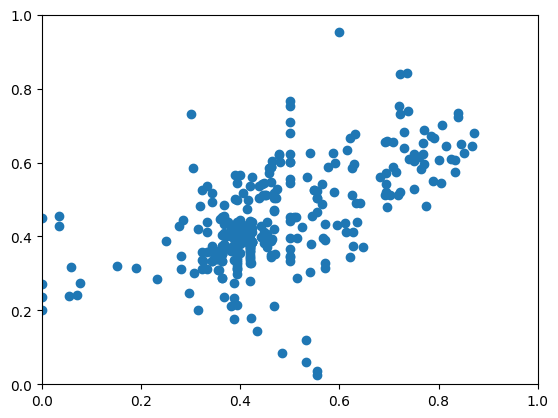

In [ ]:
plt.scatter(feldan_ft['Helical Content (hard way)'], (feldan_ft['Helical Content (easy way)']-0.8)/0.2)
plt.xlim(0, 1)
plt.ylim(0, 1)

# print the result
r2 = r2_score(feldan_ft['Helical Content (hard way)'], (feldan_ft['Helical Content (easy way)']-0.8)/0.2)
print('R-squared score:', r2)

# Feature selection

In [ ]:
# Feature selection
feldan_ft_v0 = pd.read_excel("Feldan (filled, non-standardized).xlsx", index_col = 0)
feldan_ft_nozeros = feldan_ft_v0.loc[:, (feldan_ft_v0 != 0).any(axis=0)] # Remove columns where all values are zero

feldan_cor_matrix = feldan_ft_nozeros.corr().abs()
feldan_upper_tri = feldan_cor_matrix.where(np.triu(np.ones(feldan_cor_matrix.shape), k=1).astype(np.bool))
feldan_to_drop = [column for column in feldan_upper_tri.columns if any(feldan_upper_tri[column] > 0.95)]
feldan_ft_noncor = feldan_ft_nozeros.drop(feldan_to_drop, axis=1)

scaler = StandardScaler()
feldan_ft_noncor[feldan_ft_noncor.columns] = scaler.fit_transform(feldan_ft_noncor[feldan_ft_noncor.columns])
feldan_ft = feldan_ft_noncor

#feldan_ft.to_excel("Feldan (filled, selected, standardized).xlsx")

In [ ]:
'''
cpp_df = pd.read_excel("CPP Database v2 (cleaned).xlsx", index_col = 0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cpp_ft = pd.DataFrame()
    cpp_ft = featurization(cpp_df, cpp_ft)
    cpp_ft.to_excel("CPP Database v2 (filled, non-standardized).xlsx")
'''
hybrid_ahdb_df = pd.read_excel("Hybrid AHDB (Filtered - K,R 40, HM 7, PE 50).xlsx", index_col = 0)
hybrid_ahdb_df = hybrid_ahdb_df.head(1000)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ahdb_ft = pd.DataFrame()
    ahdb_ft = featurization(hybrid_ahdb_df, ahdb_ft)
    ahdb_ft.to_excel("Hybrid AHDB (filled, non-standardized).xlsx")

nonzeros = np.where((feldan_ft_v0 != 0).any(axis=0))
ahdb_ft_nozeros = ahdb_ft.iloc[:, nonzeros[0]]

ahdb_ft_noncor = ahdb_ft_nozeros.drop(feldan_to_drop, axis=1)

ahdb_ft_noncor[ahdb_ft_noncor.columns] = scaler.transform(ahdb_ft_noncor[ahdb_ft_noncor.columns])
ahdb_ft = ahdb_ft_noncor

ahdb_ft.to_excel("Hybrid AHDB (filled, selected, standardized).xlsx")

In [ ]:
ahdb_ft.to_excel("Hybrid AHDB (filled, selected, standardized, top 1000).xlsx")

In [ ]:
nonzeros = np.where((feldan_ft_v0 != 0).any(axis=0))
cpp_ft_nozeros = cpp_ft.iloc[:, nonzeros[0]]

cpp_ft_noncor = cpp_ft_nozeros.drop(feldan_to_drop, axis=1)

display(cpp_ft_noncor)
display(feldan_ft_noncor)

cpp_ft_noncor[cpp_ft_noncor.columns] = scaler.transform(cpp_ft_noncor[cpp_ft_noncor.columns])
cpp_ft = cpp_ft_noncor

cpp_ft.to_excel("CPP Database v2 (filled, selected, standardized).xlsx")

In [ ]:
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    eep_ft = pd.DataFrame()
    eep_ft = featurization(eep_df, eep_ft)

nonzeros = np.where((feldan_ft_v0 != 0).any(axis=0))
eep_ft_nozeros = eep_ft.iloc[:, nonzeros[0]]

display(eep_ft_nozeros)
eep_ft_noncor = eep_ft_nozeros.drop(feldan_to_drop, axis=1)

display(eep_ft_noncor)

eep_ft_noncor[eep_ft_noncor.columns] = scaler.transform(eep_ft_noncor[eep_ft_noncor.columns])
eep_ft = eep_ft_noncor

eep_ft.to_excel("ELP-EEP Library (filled, selected, standardized).xlsx")

# Train-Test Split

In [ ]:
efficacy = eep_df.loc[:,"Efficacy (Cre protein)"]
n_features = eep_ft.shape[1]
n_trials = 100
result = []

for random_state in range(n_trials):
  x_train, x_test, y_train, y_test = train_test_split(eep_ft, efficacy, test_size=0.2, random_state=random_state)
  distances = list(map(lambda i : sp.stats.ks_2samp(x_train.iloc[:,i], x_test.iloc[:,i]).statistic,range(n_features)))

  
  result.append((random_state,max(distances)))

result.sort(key = lambda x : x[1])
print(result)

In [ ]:
feldan_ft = pd.read_excel("Feldan (filled, selected, standardized).xlsx", index_col = 0)
feldan_df = pd.read_excel("Feldan Data (w viability).xlsx", index_col = 0)
feldan_efficacy = feldan_df.loc[:,"Score"]
feldan_train, feldan_test, eff_train, eff_test = train_test_split(feldan_ft, feldan_efficacy, test_size = 0.2, random_state = 34) # 34 selected based on trials above

sns.histplot(eff_train)
sns.histplot(eff_test)

# w/Viability

## Lasso

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state = 0)
ls = Lasso()

Parameter_Trials={'fit_intercept':[True, False],
          'alpha':np.arange(0.01, 0.1, 0.001),
          'precompute': [True, False],
          'selection': ["random", "cyclic"]}

search = RandomizedSearchCV(ls, Parameter_Trials, n_iter=100, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

results_lasso = search.fit(feldan_train, eff_train)

pred_eff_train = results_lasso.best_estimator_.predict(feldan_train)
pred_eff_train[pred_eff_train<0] = 0
pred_eff_test = results_lasso.best_estimator_.predict(feldan_test)
pred_eff_test[pred_eff_test<0] = 0

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('RMSE: %.3f' % rmse_train)
print('R^2 = %.3f' % r2_score(eff_train, pred_eff_train))
print('RMSE (test): %.3f' % rmse_test)
print('R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))
print('Config: %s' % results_lasso.best_params_)

numcoef = 0
for i in range(len(results_lasso.best_estimator_.coef_)):
    if results_lasso.best_estimator_.coef_[i] != 0:
        numcoef = numcoef + 1

print(f'Number of coefficients: {numcoef}')

# Plot data, save as dataframe
plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df*10, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df*10, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted EV Score (a.u.)', fontsize=16)
plt.ylabel('True EV Score (a.u.)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Lasso (Shuttle Peptides)", fontsize=20)
sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
plt.show()

filename = 'Feldan Lasso (with viablity).sav'
pickle.dump(results_lasso, open(filename, 'wb'))

## Ridge

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state = 0)
rd = Ridge()

Parameter_Trials={'fit_intercept':[True, False],
                'alpha': np.arange(0.01, 0.1, 0.001),
                'solver': ['svd', 'cholesky', 'lsqr', 'saga']}

search = RandomizedSearchCV(rd, Parameter_Trials, n_iter=100, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

results_ridge = search.fit(feldan_train, eff_train)

pred_eff_train = results_ridge.best_estimator_.predict(feldan_train)
pred_eff_train[pred_eff_train<0] = 0
pred_eff_test = results_ridge.best_estimator_.predict(feldan_test)
pred_eff_test[pred_eff_test<0] = 0

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('RMSE: %.3f' % rmse_train)
print('R^2 = %.3f' % r2_score(eff_train, pred_eff_train))
print('RMSE (test): %.3f' % rmse_test)
print('R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))
print('Config: %s' % results_ridge.best_params_)

numcoef = 0
for i in range(len(results_ridge.best_estimator_.coef_)):
    if results_ridge.best_estimator_.coef_[i] != 0:
        numcoef = numcoef + 1

print(f'Number of coefficients: {numcoef}')

# Plot data, save as dataframe
plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df*10, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df*10, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted EV Score (a.u.)', fontsize=16)
plt.ylabel('True EV Score (a.u.)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Ridge (Shuttle Peptides)", fontsize=20)
sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
plt.show()

filename = 'Feldan Ridge (with viablity).sav'
pickle.dump(results_lasso, open(filename, 'wb'))

## Random Forest Regressor

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state = 0)
rf = RandomForestRegressor()

Parameter_Trials={'criterion':["squared_error", "absolute_error"],
              'n_estimators':np.arange(1, 10, 1),
              'max_depth': np.arange(1,5,1),
              'max_features': [round(np.sqrt(len(feldan_ft.columns))), 1.0],
              'bootstrap': [True]}

search = RandomizedSearchCV(rf, Parameter_Trials, n_iter=100, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

results_rf = search.fit(feldan_train, eff_train)

pred_eff_train = results_rf.best_estimator_.predict(feldan_train)
pred_eff_train[pred_eff_train<0] = 0
pred_eff_test = results_rf.best_estimator_.predict(feldan_test)
pred_eff_test[pred_eff_test<0] = 0

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('RMSE: %.3f' % rmse_train)
print('R^2 = %.3f' % r2_score(eff_train, pred_eff_train))
print('RMSE (test): %.3f' % rmse_test)
print('R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))
print('Config: %s' % results_rf.best_params_)

# Plot data, save as dataframe
plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df*10, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df*10, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted EV Score (a.u.)', fontsize=16)
plt.ylabel('True EV Score (a.u.)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Random Forest Regressor (Shuttle Peptides)", fontsize=20)
sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
plt.show()

filename = 'Feldan RFR (with viablity).sav'
pickle.dump(results_lasso, open(filename, 'wb'))

## Support Vector Regressor

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state = 0)
svr = LinearSVR()

Parameter_Trials={
              'epsilon': np.arange(0.01, 0.1, 0.01),
              'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
              'C': np.arange(0.01, 0.1, 0.01),
              'fit_intercept': [True, False]}

search = RandomizedSearchCV(svr, Parameter_Trials, n_iter=100, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

results_svr = search.fit(feldan_train, eff_train)

pred_eff_train = results_svr.best_estimator_.predict(feldan_train)
pred_eff_train[pred_eff_train<0] = 0
pred_eff_test = results_svr.best_estimator_.predict(feldan_test)
pred_eff_test[pred_eff_test<0] = 0

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('RMSE: %.3f' % rmse_train)
print('R^2 = %.3f' % r2_score(eff_train, pred_eff_train))
print('RMSE (test): %.3f' % rmse_test)
print('R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))
print('Config: %s' % results_svr.best_params_)

numcoef = 0
for i in range(len(results_svr.best_estimator_.coef_)):
    if results_svr.best_estimator_.coef_[i] != 0:
        numcoef = numcoef + 1

print(f'Number of coefficients: {numcoef}')

# Plot data, save as dataframe
plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df*10, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df*10, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted EV Score (a.u.)', fontsize=16)
plt.ylabel('True EV Score (a.u.)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Support Vector Regressor (Shuttle Peptides)", fontsize=20)
sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
plt.show()

filename = 'Feldan SVR (with viablity).sav'
pickle.dump(results_lasso, open(filename, 'wb'))

## XGBoost

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state = 0)
xgbr = xgb.XGBRegressor()

Parameter_Trials={
              'gamma': np.arange(0.01, 0.1, 0.001),
              'learning_rate':  np.arange(0.01, 1, 0.01),
              'max_depth': np.arange(1,5,1),
              'tree_method': ['auto', 'exact', 'approx', 'hist'],
              'reg_alpha': np.arange(0.01, 0.1, 0.001),
              'reg_lambda': np.arange(0.01, 0.1, 0.001)
}

search = RandomizedSearchCV(xgbr, Parameter_Trials, n_iter=100, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

results_xgb = search.fit(feldan_train, eff_train)

pred_eff_train = results_xgb.best_estimator_.predict(feldan_train)
pred_eff_train[pred_eff_train<0] = 0
pred_eff_test = results_xgb.best_estimator_.predict(feldan_test)
pred_eff_test[pred_eff_test<0] = 0

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('RMSE: %.3f' % rmse_train)
print('R^2 = %.3f' % r2_score(eff_train, pred_eff_train))
print('RMSE (test): %.3f' % rmse_test)
print('R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))
print('Config: %s' % results_xgb.best_params_)

# Plot data, save as dataframe
plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df*10, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df*10, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted EV Score (a.u.)', fontsize=16)
plt.ylabel('True EV Score (a.u.)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("XGBoost Regressor (Shuttle Peptides)", fontsize=20)
sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
plt.show()

filename = 'Feldan XGBoost (with viablity).sav'
pickle.dump(results_lasso, open(filename, 'wb'))

## MLP Regressor

In [ ]:
feldan_ft = pd.read_excel("Feldan (filled, selected, standardized).xlsx", index_col = 0)
feldan_df = pd.read_excel("Feldan Data (w viability).xlsx", index_col = 0)
feldan_efficacy = feldan_df.loc[:,"Score"]
feldan_train, feldan_test, eff_train, eff_test = train_test_split(feldan_ft, feldan_efficacy, test_size = 0.2, random_state = 34)

input_size = 948
num_epochs = 100
k = 5

train_data = PepDataset(feldan_train, eff_train)
test_data = PepDataset(feldan_test, eff_test)

In [ ]:
n_features = feldan_ft.shape[1]
n_trials = 100
result = []

for random_state in range(n_trials):
  feldan_train, feldan_test, eff_train, eff_test = train_test_split(feldan_ft, feldan_efficacy, test_size=0.2, random_state=random_state)
  distances = list(map(lambda i : sp.stats.ks_2samp(feldan_train.iloc[:,i],feldan_test.iloc[:,i]).statistic,range(n_features)))

  
  result.append((random_state,max(distances)))

result.sort(key = lambda x : x[1]) #34 is best key

In [ ]:
#Define the SigOpt experiment

conn = Connection(client_token="PCWSXPXHACQJQDLSHYAXWFXDLWPSPRYXTEUZDEKQOASVKXLL")
experiment = conn.experiments().create(
    name="Feldan Model Training (w/Viability)",
    parameters=[
        dict(name='hidden_size', type='int', bounds=dict(min=64, max=256)),
        dict(name='num_hidden_layers', type='int', bounds=dict(min=1, max=5)),
        dict(name='learning_rate', type='double', bounds=dict(min=1e-5, max=1e-2), transform='log'),
        dict(name='batch_size', type='int', bounds=dict(min=32, max=128)),
        dict(name='weight_decay', type='double', bounds=dict(min=1e-5, max=1e-3), transform='log'),
        dict(name='dropout_prob', type='double', bounds=dict(min=0.4, max=0.6)),
    ],
    observation_budget=1000,
)

# Perform hyperparameter tuning using cross-validation
for i in range(experiment.observation_budget):
    # Get a set of hyperparameters from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()

    # Train and evaluate the model with cross-validation
    val_losses = []
    train_losses = []

    # Split dataset
    split_data = random_split(train_data, [0.2, 0.2, 0.2, 0.2, 0.2])

    for j in range(k):
    
        # Split the dataset into training and validation sets
        val_indices = split_data[j].indices
        idx = [pos for pos in range(len(split_data)) if pos != j]
        train_indices = split_data[idx[0]].indices + split_data[idx[1]].indices + split_data[idx[2]].indices + split_data[idx[3]].indices

        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=train_sampler)
        val_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=val_sampler)

        # Create the model and optimizer
        model = MLP(input_size, suggestion.assignments["hidden_size"], dropout_prob = suggestion.assignments["dropout_prob"], num_hidden_layers = suggestion.assignments["num_hidden_layers"])
        optimizer = torch.optim.SGD(model.parameters(), lr=suggestion.assignments["learning_rate"], weight_decay = suggestion.assignments["weight_decay"])

        # Train the model
        for epoch in range(num_epochs):
            train_loss = train(model, train_loader, optimizer, device=device)
            train_losses.append(train_loss)
        
        avg_train_loss = round(np.mean(train_losses), 4)

        # Evaluate the model on the validation set
        val_loss = validate(model, val_loader, device)
        val_losses.append(val_loss)

    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss (Cycle {i}): {avg_val_loss}")

    # Report the observation to SigOpt
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=-avg_val_loss,
        value_stddev=0.0,
    )

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

best_batch_size = 62
best_dropout_prob = 0.4065292285819174
best_hidden_size = 70
best_learning_rate = 0.0033505314311404093
best_num_hidden_layers = 1
best_weight_decay = 0.00001
k = 5

feldan_ft = pd.read_excel("Feldan (filled, selected, standardized).xlsx", index_col = 0)
feldan_df = pd.read_excel("Feldan Data (w viability).xlsx", index_col = 0)
feldan_efficacy = feldan_df.loc[:,"Score"]
feldan_train, feldan_test, eff_train, eff_test = train_test_split(feldan_ft, feldan_efficacy, test_size = 0.2, random_state = 34)
display(eff_train)
print(type(eff_train))

train_data = PepDataset(feldan_train, eff_train)
test_data = PepDataset(feldan_test, eff_test)
split_data = random_split(train_data, [0.2, 0.2, 0.2, 0.2, 0.2])

for j in range(k):
    # Split the dataset into training and validation sets
    val_indices = split_data[j].indices
    idx = [pos for pos in range(len(split_data)) if pos != j]
    train_indices = split_data[idx[0]].indices + split_data[idx[1]].indices + split_data[idx[2]].indices + split_data[idx[3]].indices

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=val_sampler)

    # Initialize your MLP and optimizer with the best hyperparameters
    mlp = MLP(input_size=948, hidden_size=best_hidden_size, num_hidden_layers=best_num_hidden_layers, dropout_prob=best_dropout_prob)
    optimizer = torch.optim.SGD(mlp.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

    val_losses = []
    train_losses = []

    for epoch in range(200):
        train_loss = train(mlp, train_loader, optimizer, device=device)
        train_losses.append(train_loss)

        val_loss = validate(mlp, val_loader, device)
        val_losses.append(val_loss)
    '''
    plt.plot(range(200), train_losses, label="Training Loss")
    plt.plot(range(200), val_losses, label="Validation loss")
    plt.title(f"Training and Validation Loss: Fold {j}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss') 
    plt.legend()
    plt.show()
    '''

    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss: {avg_val_loss}")

mlp.eval()
pred_eff_train = mlp(feldan_train).detach().numpy()
pred_eff_train[pred_eff_train<0] = 0
pred_eff_train[pred_eff_train>100] = 100

pred_eff_test = mlp(feldan_test).detach().numpy()
pred_eff_test[pred_eff_test<0] = 0
pred_eff_test[pred_eff_test>100] = 100

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

feldan_mse_train = mean_squared_error(eff_train[:317], pred_eff_train[:317])
feldan_rmse_train = math.sqrt(feldan_mse_train)
feldan_mse_test = mean_squared_error(eff_test.iloc[:80], pred_eff_test[:80])
feldan_rmse_test = math.sqrt(feldan_mse_test)

# Summarize features of best model
print('Overall RMSE (train): %.3f' % rmse_train)
print('Overall R^2 (train)= %.3f' % r2_score(eff_train, pred_eff_train))
print('Overall RMSE (test): %.3f' % rmse_test)
print('Overall R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))

# Plot data, save as dataframe
fig = plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted Score (a.u.)', fontsize=16)
plt.ylabel('True Score (a.u.)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("MLP Regressor (Shuttle Peptides)", fontsize=20)
sns.lineplot(x=np.arange(0, 10.1, 0.1), y=np.arange(0, 10.1, 0.1), c='red', linestyle="dashed")
plt.show()

In [ ]:
filename = 'MLP Regressor (with viability, no self-training).sav'
pickle.dump(mlp, open(filename, 'wb'))

### Self Training

In [ ]:
class PepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

class MLP(nn.Module):
      def __init__(self, input_size, hidden_size, num_hidden_layers, dropout_prob):
          super().__init__()
          self.layers = nn.ModuleList()
          self.layers.append(nn.Linear(input_size, hidden_size))
          for i in range(num_hidden_layers-1):
              self.layers.append(nn.Linear(hidden_size, hidden_size))
          self.dropout = nn.Dropout(dropout_prob)
          self.relu = nn.ReLU()
          self.output_layer = nn.Linear(hidden_size, 1)

      def forward(self, x):
          for layer in self.layers:
              if not isinstance(x, torch.Tensor):
                x = torch.tensor(x.values, dtype=torch.float32)
              x = self.relu(layer(x))
              x = self.dropout(x)
          x = self.output_layer(x)
          return x

def train(model, train_loader, optimizer, device):
    epoch_loss = []
    model.train()
    for batch in train_loader:  
        X, y = batch

        # train your model on each batch here 
        y_pred = model(X)
        y_pred[y_pred < 0] = 0
        y_pred[y_pred > 100] = 100
        loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred,y.unsqueeze(1)))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return np.array(epoch_loss).mean()

def validate(model, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():    
      for batch in val_loader:
          X, y = batch

          # validate your model on each batch here 
          y_pred = model(X)
          y_pred[y_pred < 0] = 0
          y_pred[y_pred > 100] = 100

          loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred, y.unsqueeze(1)))
          val_loss.append(loss.item())
            
    return np.array(val_loss).mean()

def predict_proba(X, model, num_samples):
    model.train()
    preds = [model(X) for i in range(num_samples)]
    return preds


In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

best_batch_size = 62
best_dropout_prob = 0.4065292285819174
best_hidden_size = 70
best_learning_rate = 0.0033505314311404093
best_num_hidden_layers = 1
best_weight_decay = 0.00001
k = 5
device = 'cuda:0'

cpp_batchsizes = [20]

cset = tol_cset('prism')
for b in range(len(cpp_batchsizes)):
  feldan_ft = pd.read_excel("Feldan (filled, selected, standardized).xlsx", index_col = 0)
  feldan_df = pd.read_excel("Feldan Data (w viability).xlsx", index_col = 0)
  feldan_efficacy = feldan_df.loc[:,"Score"]
  feldan_train, feldan_test, eff_train, eff_test = train_test_split(feldan_ft, feldan_efficacy, test_size = 0.2, random_state = 34)
  train_data = PepDataset(feldan_train, eff_train)
  test_data = PepDataset(feldan_test, eff_test)
  cpps = pd.read_excel("CPP Database v2 (cleaned).xlsx", index_col=0)
  cpp_ft = pd.read_excel("CPP Database v2 (filled, selected, standardized).xlsx", index_col = 0)

  avg_overall_std = []
  avg_top10_std = []
  overall_train_rmse_array = []
  overall_test_rmse_array = []
  feldan_train_rmse_array = []
  feldan_test_rmse_array = []
  
  print(f"Batch size = {cpp_batchsizes[b]}")
  for i in range(math.floor(len(cpps)/cpp_batchsizes[b])):
    print(f"Peptides {i*cpp_batchsizes[b]} to {i*cpp_batchsizes[b]+(cpp_batchsizes[b]-1)} in CPP Database")
    split_data = random_split(train_data, [0.2, 0.2, 0.2, 0.2, 0.2])
    val_losses = []
    for j in range(k):
      # Split the dataset into training and validation sets
      val_indices = split_data[j].indices
      idx = [pos for pos in range(len(split_data)) if pos != j]
      train_indices = split_data[idx[0]].indices + split_data[idx[1]].indices + split_data[idx[2]].indices + split_data[idx[3]].indices

      train_sampler = SubsetRandomSampler(train_indices)
      val_sampler = SubsetRandomSampler(val_indices)
      train_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=train_sampler)
      val_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=val_sampler)

      # Initialize your MLP and optimizer with the best hyperparameters
      mlp = MLP(input_size=948, hidden_size=best_hidden_size, num_hidden_layers=best_num_hidden_layers, dropout_prob=best_dropout_prob)
      optimizer = torch.optim.SGD(mlp.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)
      train_losses = []

      for epoch in range(100):
          train_loss = train(mlp, train_loader, optimizer, device=device)
          train_losses.append(train_loss)

      val_loss = validate(mlp, val_loader, device)
      val_losses.append(val_loss)

    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss: {avg_val_loss}")
      
    mlp.eval()
    pred_eff_train = mlp(feldan_train).detach().numpy()
    pred_eff_train[pred_eff_train<0] = 0
    pred_eff_train[pred_eff_train>100] = 100

    pred_eff_test = mlp(feldan_test).detach().numpy()
    pred_eff_test[pred_eff_test<0] = 0
    pred_eff_test[pred_eff_test>100] = 100

    mse_train = mean_squared_error(eff_train, pred_eff_train)
    rmse_train = math.sqrt(mse_train)
    mse_test = mean_squared_error(eff_test, pred_eff_test)
    rmse_test = math.sqrt(mse_test)

    feldan_mse_train = mean_squared_error(eff_train[:317], pred_eff_train[:317])
    feldan_rmse_train = math.sqrt(feldan_mse_train)
    feldan_mse_test = mean_squared_error(eff_test.iloc[:80], pred_eff_test[:80])
    feldan_rmse_test = math.sqrt(feldan_mse_test)

    overall_train_rmse_array.append(rmse_train)
    overall_test_rmse_array.append(rmse_test)

    feldan_train_rmse_array.append(feldan_rmse_train)
    feldan_test_rmse_array.append(feldan_rmse_test)

    # Plot data, save as dataframe

    yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
    yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
    yvalues_train_df.iloc[:, 1] = pred_eff_train

    yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
    yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
    yvalues_test_df.iloc[:, 1] = pred_eff_test

    num_samples = 100
    y_pred = predict_proba(cpp_ft, mlp, num_samples)
    predictions = np.zeros((len(y_pred[0].detach().numpy()), num_samples))

    for m in range(num_samples):
        predictions[:, m] = y_pred[m].detach().numpy().squeeze()

    for m in range(len(cpps)):
      if np.mean(predictions[m]) < 0:
        cpps.loc[cpps.index[m], "Average Efficacy"] = 0
        cpps.loc[cpps.index[m], "Standard Deviation"] = np.std(predictions[m])

      if np.mean(predictions[m]) > 100:
        cpps.loc[cpps.index[m], "Average Efficacy"] = 100
        cpps.loc[cpps.index[m], "Standard Deviation"] = np.std(predictions[m])

      else: 
        cpps.loc[cpps.index[m], "Average Efficacy"] = np.mean(predictions[m])
        cpps.loc[cpps.index[m], "Standard Deviation"] = np.std(predictions[m])

    lowest_row = cpp_ft.loc[cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index, :]
    lowest_rows_mean = cpps.loc[cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index, "Average Efficacy"]
    lowest_rows_std = cpps.loc[cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index, "Standard Deviation"]

    avg_overall_std.append(cpps["Standard Deviation"].mean())
    avg_top10_std.append(lowest_rows_std.mean())

    print(f"Running Standard Deviation: {np.mean(avg_overall_std[i-2:i+1])}")
    if np.mean(avg_overall_std[i-2:i+1]) > 10:
      break

    training_samples, testing_samples, training_eff, testing_eff = train_test_split(lowest_row, lowest_rows_mean, test_size=0.2)
    feldan_train = pd.concat([feldan_train, training_samples])
    feldan_test = pd.concat([feldan_test, testing_samples])

    eff_train = pd.concat([eff_train, training_eff])
    eff_train[eff_train<0] = 0
    eff_train[eff_train>100] = 100

    eff_test = pd.concat([eff_test, testing_eff])
    eff_test[eff_test<0] = 0
    eff_test[eff_test>100] = 100


    print(cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index, lowest_rows_std, lowest_rows_mean, "\n")

    cpp_ft = cpp_ft.drop(cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index)
    cpps = cpps.drop(cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index)

    train_data = PepDataset(feldan_train, eff_train)
  
  plt.figure(figsize=(8,5))
  plt.plot(range(i+1), overall_train_rmse_array, label= "Overall Train RMSE", color='0.8', linewidth=3)
  plt.plot(range(i+1), overall_test_rmse_array, label = "Overall Test RMSE", color='#056eee', linewidth=3)
  plt.plot(range(i+1), feldan_train_rmse_array, label= "Shuttle peptide Train RMSE", color='0.2', linewidth=3)
  plt.plot(range(i+1), feldan_test_rmse_array, label = "Shuttle Test RMSE", color='#2ca02c', linewidth=3)
  plt.title("Train and Test RMSE", fontsize=20)
  plt.xlabel('Batch', fontsize=16)
  plt.ylabel('RMSE', fontsize=16) 
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.legend()
  plt.show()

  # Summarize features of best model
  print('Overall RMSE (train): %.3f' % rmse_train)
  print('Overall R^2 (train)= %.3f' % r2_score(eff_train, pred_eff_train))
  print('Overall RMSE (test): %.3f' % rmse_test)
  print('Overall R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))

  print('Feldan RMSE (train): %.3f' % feldan_rmse_train)
  print('Feldan R^2 (train)= %.3f' % r2_score(eff_train.iloc[:317], pred_eff_train[:317]))
  print('Feldan RMSE (test): %.3f' % feldan_rmse_test)
  print('Feldan R^2 (test) = %.3f' % r2_score(eff_test.iloc[:80], pred_eff_test[:80]))

  plt.figure(figsize=(8,5))
  ax = sns.scatterplot(data = yvalues_train_df.iloc[:317], x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
  sns.scatterplot(data = yvalues_train_df.iloc[317:], x="yhat_train", y="y_train", c='0.2', s=50, edgecolor="none")
  sns.scatterplot(data = yvalues_test_df.iloc[:80], x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")
  sns.scatterplot(data = yvalues_test_df.iloc[80:], x="yhat_test", y="y_test", c='#2ca02c', s=50, edgecolor="none")

  plt.xlabel('Predicted EV Score (a.u.)', fontsize=16)
  plt.ylabel('True EV Score (a.u.)', fontsize=16)
  plt.legend(["Original train data", "CPPD train data", "Original test data", "CPPD test data"])
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.title("MLP Regressor", fontsize=20)
  sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
  plt.show()

  plt.figure(figsize=(8,5))
  plt.plot(range(i+1), avg_overall_std, label= "Average Overall Standard Deviation", color='0.8', linewidth=3)
  plt.plot(range(i+1), avg_top10_std, label = "Average 10 lowest Standard Deviation", color='#056eee', linewidth=3)
  plt.title("Average Peptide Batch Standard Deviation", fontsize=20)
  plt.xlabel('Peptide Batch', fontsize=16)
  plt.ylabel('Standard Deviation', fontsize=16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16) 
  plt.legend()
  plt.show()

  yvalues_train_df.to_excel(f"Feldan + CPPD Train Data (Batch size {cpp_batchsizes[b]}).xlsx")
  yvalues_test_df.to_excel(f"Feldan + CPPD Test Data (Batch size {cpp_batchsizes[b]}).xlsx")

  filename = f'Average Overall Standard Deviation (Batch size {cpp_batchsizes[b]}).csv'
  filename1 = f'Average Top 10 Standard Deviation (Batch size {cpp_batchsizes[b]}).csv'
  filename2 = f'Average Overall Train RMSE (Batch size {cpp_batchsizes[b]}).csv'
  filename3 = f'Average Overall Test RMSE (Batch size {cpp_batchsizes[b]}).csv'
  filename4 = f'Average Shuttle Train RMSE (Batch size {cpp_batchsizes[b]}).csv'
  filename5 = f'Average Shuttle Test RMSE (Batch size {cpp_batchsizes[b]}).csv'

  filename_array = [filename, filename1, filename2, filename3, filename4, filename5]
  value_list = [[avg_overall_std], [avg_top10_std], [overall_train_rmse_array], [overall_test_rmse_array], [feldan_train_rmse_array], [feldan_test_rmse_array]]

  for i in range(len(filename_array)):
    with open(filename_array[i], mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(value_list[i])

filename = 'MLP Regressor (with viablity, with self training).sav'
pickle.dump(mlp, open(filename, 'wb'))



### ELP Fit Assessment

In [ ]:
from sklearn.preprocessing import MinMaxScaler

with open('MLP Regressor (with viablity, with self training).sav', 'rb') as f:
      mlp = pickle.load(f)


eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
cre_protein_eff = eep_df.loc[:, "Efficacy (Cre protein)"]
eep_train, eep_test, eff_train, eff_test = train_test_split(eep_ft, cre_protein_eff, test_size = 0.2, random_state = 0)
                                                              
prediction = mlp(eep_ft).detach().numpy()
prediction[prediction < 0] = 0

scaler = MinMaxScaler()
eff_normalized = scaler.fit_transform(cre_protein_eff.values.reshape(-1, 1))
prediction_normalized = scaler.fit_transform(prediction)

plt.figure(figsize=(8,5))
plt.scatter(prediction_normalized*100, eff_normalized*100, color='#056eee')
plt.axhline(y=20, color='r', linestyle='-')
plt.axvline(x=20, color='g', linestyle='-')
plt.title("Model Prediction (w/viability) vs. Cre protein Efficacy (normalized)", fontsize=16)
plt.xlabel("Model Prediction (a.u.)", fontsize=16)
plt.ylabel("Cre protein Efficacy (a.u.)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

eep_feldan_df = pd.DataFrame(index=eep_df.index)
eep_feldan_df["GFP protein efficacy (Feldan)"] = prediction_normalized*100
eep_feldan_df["Cre protein efficacy"] = eff_normalized*100


### Transfer Learning

In [ ]:
with open('MLP Regressor (with viablity, with self training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
input_size = 70
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

mlp.eval()

eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
eep_train, eep_test, eff_train, eff_test = train_test_split(eep_ft, eep_df.loc[:, "Efficacy (Cre protein)"], test_size = 0.2, random_state = 75)

eep_train_mlp = mlp(eep_train).detach().numpy()
eep_test_mlp = mlp(eep_test).detach().numpy()

#### Linear combination (Lasso)

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state = 0)
ls = Lasso()

Parameter_Trials={'fit_intercept':[True, False],
          'alpha':np.arange(0.1, 1, 0.01),
          'precompute': [True, False],
          'selection': ["random", "cyclic"]}

search = RandomizedSearchCV(ls, Parameter_Trials, n_iter=100, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

results_lasso = search.fit(eep_train_mlp, eff_train)

pred_eff_train = results_lasso.best_estimator_.predict(eep_train_mlp)
pred_eff_train[pred_eff_train<0] = 0
pred_eff_train[pred_eff_train>100] = 100
pred_eff_test = results_lasso.best_estimator_.predict(eep_test_mlp)
pred_eff_test[pred_eff_test<0] = 0
pred_eff_test[pred_eff_test>100] = 100

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('RMSE: %.3f' % rmse_train)
print('R^2 = %.3f' % r2_score(eff_train, pred_eff_train))
print('RMSE (test): %.3f' % rmse_test)
print('R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))
print('Config: %s' % results_lasso.best_params_)

numcoef = 0
for i in range(len(results_lasso.best_estimator_.coef_)):
    if results_lasso.best_estimator_.coef_[i] != 0:
        numcoef = numcoef + 1

print(f'Number of coefficients: {numcoef}')

# Plot data, save as dataframe

yvalues_train_df = pd.DataFrame(index=eep_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=eep_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

plt.figure(figsize=(8,5))
ax = sns.scatterplot(data = yvalues_train_df, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted RFP+ (%)', fontsize=16)
plt.ylabel('True RFP+ (%)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EEP Fine Tuning (Linear Feature Combination)", fontsize=18)
sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
plt.show()

filename = 'EEP Transfer Learning Lasso (with viablity).sav'
pickle.dump(results_lasso, open(filename, 'wb'))

display(yvalues_test_df)

#### Non-linear combination (MLP)

In [ ]:
class MLP_EEP(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
      for layer in self.layers:
        x = self.relu(layer(x))
        x = self.dropout(x)
      x = self.output_layer(x)
      return x

def train(model, train_loader, optimizer, device):
    epoch_loss = []
    model.train()
    for batch in train_loader:  
        X, y = batch

        # train your model on each batch here 
        y_pred = model(X)
        y_pred[y_pred < 0] = 0
        y_pred[y_pred > 100] = 100
        loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred,y.unsqueeze(1)))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return np.array(epoch_loss).mean()

def validate(model, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():    
      for batch in val_loader:
          X, y = batch

          # validate your model on each batch here 
          y_pred = model(X)
          y_pred[y_pred < 0] = 0
          y_pred[y_pred > 100] = 100

          loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred, y.unsqueeze(1)))
          val_loss.append(loss.item())
            
    return np.array(val_loss).mean()

with open('MLP Regressor (with viablity, with self training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
input_size = 70
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
eep_train, eep_test, eff_train, eff_test = train_test_split(eep_ft, eep_df.loc[:, "Efficacy (Cre protein)"], test_size = 0.2, random_state = 75)

import torch.nn.functional as F

mlp.eval()  # set model1 to evaluation mode

# pass your data through model1 to get the output activations
with torch.no_grad():
    output_activations_train = mlp(eep_train)
    output_activations_test = mlp(eep_test)

# reshape the output activations to the appropriate shape for the input of model2
output_activations_train = output_activations_train.view(output_activations_train.size(0), -1)
output_activations_test = output_activations_test.view(output_activations_test.size(0), -1)

conn = Connection(client_token="FZKDOQAMJLLEPLKOSMMJXNMYNDJFRCQYCQVEIROZTHKLHDWD")
experiment = conn.experiments().create(
    name="ELP-EEP Cre protein Transfer Learning",
    parameters=[
        dict(name='learning_rate', type='double', bounds=dict(min=1e-5, max=1e-2), transform='log'),
        dict(name='batch_size', type='int', bounds=dict(min=2, max=16)),
        dict(name='weight_decay', type='double', bounds=dict(min=1e-4, max=1e-2), transform='log'),
        dict(name='hidden_size', type='int', bounds=dict(min=8, max=64)),
        dict(name='dropout_prob', type='double', bounds=dict(min=0.2, max=0.5))
    ],
    observation_budget=1000,
)

train_data = PepDataset(output_activations_train, eff_train)
test_data = PepDataset(output_activations_test, eff_test)

random.seed(0)
n_folds = len(train_data) // 5
fold_size = 5

# Perform hyperparameter tuning using cross-validation
for i in range(experiment.observation_budget):

    # Get a set of hyperparameters from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()
    val_losses = []

    for j in range(n_folds):
      # generate the indices for the current fold
      fold_indices = list(range(j * fold_size, (j + 1) * fold_size))

      # Split the dataset into training and validation sets
      val_indices = fold_indices
      train_indices = [m for m in range(len(train_data)) if m not in fold_indices]

      # create the samplers and data loaders for the current fold
      train_sampler = SubsetRandomSampler(train_indices)
      val_sampler = SubsetRandomSampler(val_indices)
      train_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=train_sampler)
      val_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=val_sampler)
    

      # Initialize your MLP and optimizer with the best hyperparameters
      model = MLP_EEP(input_size, suggestion.assignments["hidden_size"], dropout_prob = suggestion.assignments["dropout_prob"])
      optimizer = torch.optim.SGD(model.parameters(), lr=suggestion.assignments["learning_rate"], weight_decay = suggestion.assignments["weight_decay"])
      train_losses = []
    
      # Train the model
      for epoch in range(200):
          train_loss = train(model, train_loader, optimizer, device=device)
          train_losses.append(train_loss)

      avg_train_loss = round(np.mean(train_losses), 4)
      val_loss = validate(model, val_loader, device)
      val_losses.append(val_loss)

    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss Trial {i}: {avg_val_loss}")

    # Report the observation to SigOpt
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=-avg_val_loss,
        value_stddev=0.0,
    )

In [ ]:
with open('/content/MLP Regressor (with viablity, with self training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
input_size = 70
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

mlp.eval()  # set model1 to evaluation mode

# pass your data through model1 to get the output activations
with torch.no_grad():
    output_activations_train = mlp(eep_train)
    output_activations_test = mlp(eep_test)

# reshape the output activations to the appropriate shape for the input of model2
output_activations_train = output_activations_train.view(output_activations_train.size(0), -1)
output_activations_test = output_activations_test.view(output_activations_test.size(0), -1)


best_batch_size = 4
best_learning_rate = 0.004416926761734289
best_weight_decay = 0.009264155107061306
best_hidden_size = 49
best_dropout_prob = 0.4259243110410555

eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col = 0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)

train_data = PepDataset(output_activations_train, eff_train)
test_data = PepDataset(output_activations_test, eff_test)

random.seed(0)
n_folds = len(train_data) // 5
fold_size = 5

val_losses = []
for j in range(n_folds):
    # generate the indices for the current fold
    fold_indices = list(range(j * fold_size, (j + 1) * fold_size))

    # Split the dataset into training and validation sets
    val_indices = fold_indices
    train_indices = [m for m in range(len(train_data)) if m not in fold_indices]

    # create the samplers and data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=val_sampler)
  

    # Initialize your MLP and optimizer with the best hyperparameters
    model = MLP_EEP(input_size = 70, hidden_size=best_hidden_size, dropout_prob=best_dropout_prob)
    optimizer = torch.optim.SGD(model.parameters(), lr=best_learning_rate, weight_decay = best_weight_decay)
    
    train_losses = []
  
    # Train the model
    for epoch in range(500):
        train_loss = train(model, train_loader, optimizer, device=device)
        train_losses.append(train_loss)

    avg_train_loss = round(np.mean(train_losses), 4)
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)
    print(f"Validation Loss Fold {j}: {val_loss}")

# Report the average validation loss and accuracy
avg_val_loss = round(np.mean(val_losses), 4)
print(f"Average Validation Loss Trial: {avg_val_loss}")


model.eval()
pred_eff_train = model(output_activations_train).detach().numpy()
pred_eff_train[pred_eff_train<0] = 0
pred_eff_train[pred_eff_train>100] = 100

pred_eff_test = model(output_activations_test).detach().numpy()
pred_eff_test[pred_eff_test<0] = 0
pred_eff_test[pred_eff_test>100] = 100

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('Overall RMSE (train): %.3f' % rmse_train)
print('Overall R^2 (train)= %.3f' % r2_score(eff_train, pred_eff_train))
print('Overall RMSE (test): %.3f' % rmse_test)
print('Overall R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))

# Plot data, save as dataframe
fig = plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=eff_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=eff_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted Efficacy', fontsize=16)
plt.ylabel('True Efficacy', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EEP Fine Tuning (Non-linear feature combination)", fontsize=18)
sns.lineplot(x=np.arange(0, 100, 1), y=np.arange(0, 100, 1), c='red', linestyle="dashed")
ax.set(xlim=(0, 100), ylim=(0, 100))
plt.show()

display(yvalues_test_df)

In [ ]:
filename = 'MLP Regressor (w viability, selftrained, transfer learning, non-linear).sav'
pickle.dump(model, open(filename, 'wb'))

### Transfer Learning (no self training)

In [ ]:
with open('MLP Regressor (with viability, no self-training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
input_size = 70
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

mlp.eval()

eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
eep_train, eep_test, eff_train, eff_test = train_test_split(eep_ft, eep_df.loc[:, "Efficacy (Cre protein)"], test_size = 0.2, random_state = 75)

eep_train_mlp = mlp(eep_train).detach().numpy()
eep_test_mlp = mlp(eep_test).detach().numpy()

#### Linear combination (Lasso)

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state = 0)
ls = Lasso()

Parameter_Trials={'fit_intercept':[True, False],
          'alpha':np.arange(0.1, 1, 0.01),
          'precompute': [True, False],
          'selection': ["random", "cyclic"]}

search = RandomizedSearchCV(ls, Parameter_Trials, n_iter=100, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

results_lasso = search.fit(eep_train_mlp, eff_train)

pred_eff_train = results_lasso.best_estimator_.predict(eep_train_mlp)
pred_eff_train[pred_eff_train<0] = 0
pred_eff_train[pred_eff_train>100] = 100
pred_eff_test = results_lasso.best_estimator_.predict(eep_test_mlp)
pred_eff_test[pred_eff_test<0] = 0
pred_eff_test[pred_eff_test>100] = 100

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('RMSE: %.3f' % rmse_train)
print('R^2 = %.3f' % r2_score(eff_train, pred_eff_train))
print('RMSE (test): %.3f' % rmse_test)
print('R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))
print('Config: %s' % results_lasso.best_params_)

numcoef = 0
for i in range(len(results_lasso.best_estimator_.coef_)):
    if results_lasso.best_estimator_.coef_[i] != 0:
        numcoef = numcoef + 1

print(f'Number of coefficients: {numcoef}')

# Plot data, save as dataframe

yvalues_train_df = pd.DataFrame(index=eep_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=eep_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

plt.figure(figsize=(8,5))
ax = sns.scatterplot(data = yvalues_train_df, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted RFP+ (%)', fontsize=16)
plt.ylabel('True RFP+ (%)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EEP Fine Tuning (Linear Feature Combination)", fontsize=18)
sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
plt.show()

filename = 'EEP Transfer Learning Lasso (with viablity).sav'
pickle.dump(results_lasso, open(filename, 'wb'))

display(yvalues_test_df)

#### Non-linear combination (MLP)

In [ ]:
class MLP_EEP(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
      for layer in self.layers:
        x = self.relu(layer(x))
        x = self.dropout(x)
      x = self.output_layer(x)
      return x

def train(model, train_loader, optimizer, device):
    epoch_loss = []
    model.train()
    for batch in train_loader:  
        X, y = batch

        # train your model on each batch here 
        y_pred = model(X)
        y_pred[y_pred < 0] = 0
        y_pred[y_pred > 100] = 100
        loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred,y.unsqueeze(1)))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return np.array(epoch_loss).mean()

def validate(model, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():    
      for batch in val_loader:
          X, y = batch

          # validate your model on each batch here 
          y_pred = model(X)
          y_pred[y_pred < 0] = 0
          y_pred[y_pred > 100] = 100

          loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred, y.unsqueeze(1)))
          val_loss.append(loss.item())
            
    return np.array(val_loss).mean()

with open('MLP Regressor (with viability, no self-training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
input_size = 70
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
eep_train, eep_test, eff_train, eff_test = train_test_split(eep_ft, eep_df.loc[:, "Efficacy (Cre protein)"], test_size = 0.2, random_state = 75)

import torch.nn.functional as F

mlp.eval()  # set model1 to evaluation mode

# pass your data through model1 to get the output activations
with torch.no_grad():
    output_activations_train = mlp(eep_train)
    output_activations_test = mlp(eep_test)

# reshape the output activations to the appropriate shape for the input of model2
output_activations_train = output_activations_train.view(output_activations_train.size(0), -1)
output_activations_test = output_activations_test.view(output_activations_test.size(0), -1)

conn = Connection(client_token="ELISRXSEZDTXSFASMPREZGEHHRRUCYMBYCCBOBYVKJYMLKIZ")
experiment = conn.experiments().create(
    name="ELP-EEP Cre protein Transfer Learning (with viability, no self-training)",
    parameters=[
        dict(name='learning_rate', type='double', bounds=dict(min=1e-5, max=1e-2), transform='log'),
        dict(name='batch_size', type='int', bounds=dict(min=2, max=16)),
        dict(name='weight_decay', type='double', bounds=dict(min=1e-4, max=1e-2), transform='log'),
        dict(name='hidden_size', type='int', bounds=dict(min=8, max=64)),
        dict(name='dropout_prob', type='double', bounds=dict(min=0.2, max=0.5))
    ],
    observation_budget=1000,
)

train_data = PepDataset(output_activations_train, eff_train)
test_data = PepDataset(output_activations_test, eff_test)

random.seed(0)
n_folds = len(train_data) // 5
fold_size = 5

# Perform hyperparameter tuning using cross-validation
for i in range(experiment.observation_budget):

    # Get a set of hyperparameters from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()
    val_losses = []

    for j in range(n_folds):
      # generate the indices for the current fold
      fold_indices = list(range(j * fold_size, (j + 1) * fold_size))

      # Split the dataset into training and validation sets
      val_indices = fold_indices
      train_indices = [m for m in range(len(train_data)) if m not in fold_indices]

      # create the samplers and data loaders for the current fold
      train_sampler = SubsetRandomSampler(train_indices)
      val_sampler = SubsetRandomSampler(val_indices)
      train_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=train_sampler)
      val_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=val_sampler)
    

      # Initialize your MLP and optimizer with the best hyperparameters
      model = MLP_EEP(input_size, suggestion.assignments["hidden_size"], dropout_prob = suggestion.assignments["dropout_prob"])
      optimizer = torch.optim.SGD(model.parameters(), lr=suggestion.assignments["learning_rate"], weight_decay = suggestion.assignments["weight_decay"])
      train_losses = []
    
      # Train the model
      for epoch in range(200):
          train_loss = train(model, train_loader, optimizer, device=device)
          train_losses.append(train_loss)

      avg_train_loss = round(np.mean(train_losses), 4)
      val_loss = validate(model, val_loader, device)
      val_losses.append(val_loss)

    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss Trial {i}: {avg_val_loss}")

    # Report the observation to SigOpt
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=-avg_val_loss,
        value_stddev=0.0,
    )

FileNotFoundError: ignored

In [ ]:
with open('/content/MLP Regressor (with viability, no self-training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
input_size = 70
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

mlp.eval()  # set model1 to evaluation mode

# pass your data through model1 to get the output activations
with torch.no_grad():
    output_activations_train = mlp(eep_train)
    output_activations_test = mlp(eep_test)

# reshape the output activations to the appropriate shape for the input of model2
output_activations_train = output_activations_train.view(output_activations_train.size(0), -1)
output_activations_test = output_activations_test.view(output_activations_test.size(0), -1)


best_batch_size = 4
best_learning_rate = 0.00712396821266261
best_weight_decay = 0.007845668286515624
best_hidden_size = 33
best_dropout_prob = 0.32830329137924796

eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col = 0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)

train_data = PepDataset(output_activations_train, eff_train)
test_data = PepDataset(output_activations_test, eff_test)

random.seed(0)
n_folds = len(train_data) // 5
fold_size = 5

val_losses = []
for j in range(n_folds):
    # generate the indices for the current fold
    fold_indices = list(range(j * fold_size, (j + 1) * fold_size))

    # Split the dataset into training and validation sets
    val_indices = fold_indices
    train_indices = [m for m in range(len(train_data)) if m not in fold_indices]

    # create the samplers and data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=val_sampler)
  

    # Initialize your MLP and optimizer with the best hyperparameters
    model = MLP_EEP(input_size = 70, hidden_size=best_hidden_size, dropout_prob=best_dropout_prob)
    optimizer = torch.optim.SGD(model.parameters(), lr=best_learning_rate, weight_decay = best_weight_decay)
    
    train_losses = []
  
    # Train the model
    for epoch in range(200):
        train_loss = train(model, train_loader, optimizer, device=device)
        train_losses.append(train_loss)

    avg_train_loss = round(np.mean(train_losses), 4)
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)
    print(f"Validation Loss Fold {j}: {val_loss}")

# Report the average validation loss and accuracy
avg_val_loss = round(np.mean(val_losses), 4)
print(f"Average Validation Loss Trial: {avg_val_loss}")


model.eval()
pred_eff_train = model(output_activations_train).detach().numpy()
pred_eff_train[pred_eff_train<0] = 0
pred_eff_train[pred_eff_train>100] = 100

pred_eff_test = model(output_activations_test).detach().numpy()
pred_eff_test[pred_eff_test<0] = 0
pred_eff_test[pred_eff_test>100] = 100

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('Overall RMSE (train): %.3f' % rmse_train)
print('Overall R^2 (train)= %.3f' % r2_score(eff_train, pred_eff_train))
print('Overall RMSE (test): %.3f' % rmse_test)
print('Overall R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))

# Plot data, save as dataframe
fig = plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=eff_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=eff_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted Efficacy', fontsize=16)
plt.ylabel('True Efficacy', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EEP Fine Tuning (Non-linear feature combination)", fontsize=18)
sns.lineplot(x=np.arange(0, 100, 1), y=np.arange(0, 100, 1), c='red', linestyle="dashed")
ax.set(xlim=(0, 100), ylim=(0, 100))
plt.show()

display(yvalues_test_df)

### Feldan Fit Assessment

In [ ]:
from sklearn.preprocessing import MinMaxScaler

with open('/content/MLP Regressor (w viability, selftrained, protein tl only output).sav', 'rb') as f:
      mlp = pickle.load(f)

feldan_ft = pd.read_excel("Feldan (filled, selected, standardized).xlsx", index_col=0)
feldan_df = pd.read_excel("Feldan Data (w viability).xlsx", index_col = 0)
feldan_score = feldan_df.loc[:, "Score"]

mlp.eval()           
prediction = mlp(feldan_ft).detach().numpy()
prediction[prediction < 0] = 0

scaler = MinMaxScaler()
feldan_score_normalized = scaler.fit_transform(feldan_score.values.reshape(-1, 1))
prediction_normalized = scaler.fit_transform(prediction)

plt.figure()
plt.scatter(prediction_normalized*100, feldan_score_normalized*100)
plt.axhline(y=20, color='r', linestyle='-')
plt.axvline(x=20, color='g', linestyle='-')
plt.title("ELP-EEP Model Prediction vs. Shuttle Peptide Score (normalized)")
plt.xlabel("Model Prediction (a.u.)")
plt.ylabel("Score (a.u.)")

'''
eep_feldan_df = pd.DataFrame(index=eep_df.index)
eep_feldan_df["GFP protein efficacy (Feldan)"] = prediction_normalized*100
eep_feldan_df["Cre protein efficacy"] = cre_protein_eff_normalized*100
eep_feldan_df["Cre mRNA efficacy"] = cre_mRNA_eff_normalized*100
display(eep_feldan_df)
'''

# w/o Viability

## MLP Regressor

In [ ]:
assert torch.cuda.device_count() != 0

In [ ]:
device = 'cuda:0'

class PepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

class MLP(nn.Module):
      def __init__(self, input_size, hidden_size, num_hidden_layers, dropout_prob):
          super().__init__()
          self.layers = nn.ModuleList()
          self.layers.append(nn.Linear(input_size, hidden_size))
          for i in range(num_hidden_layers-1):
              self.layers.append(nn.Linear(hidden_size, hidden_size))
          self.dropout = nn.Dropout(dropout_prob)
          self.relu = nn.ReLU()
          self.output_layer = nn.Linear(hidden_size, 1)

      def forward(self, x):
          for layer in self.layers:
              if not isinstance(x, torch.Tensor):
                x = torch.tensor(x.values, dtype=torch.float32)
              x = self.relu(layer(x))
              x = self.dropout(x)
          x = self.output_layer(x)
          return x

def train(model, train_loader, optimizer, device):
    epoch_loss = []
    model.train()
    for batch in train_loader:  
        X, y = batch

        # train your model on each batch here 
        y_pred = model(X)
        y_pred[y_pred < 0] = 0
        y_pred[y_pred > 10] = 10
        loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred,y.unsqueeze(1)))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return np.array(epoch_loss).mean()

def validate(model, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():    
      for batch in val_loader:
          X, y = batch

          # validate your model on each batch here 
          y_pred = model(X)
          y_pred[y_pred < 0] = 0
          y_pred[y_pred > 10] = 10

          loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred, y.unsqueeze(1)))
          val_loss.append(loss.item())
            
    return np.array(val_loss).mean()

def predict_proba(X, model, num_samples):
    model.train()
    preds = [model(X) for i in range(num_samples)]
    return preds


In [ ]:
feldan_ft = pd.read_excel("Feldan (filled, selected, standardized).xlsx", index_col = 0)
feldan_df = pd.read_excel("Feldan Sequences.xlsx", index_col = 0)
feldan_efficacy = feldan_df.loc[:,"Efficacy"]
feldan_train, feldan_test, eff_train, eff_test = train_test_split(feldan_ft, feldan_efficacy, test_size = 0.2, random_state = 34)

#cpps = pd.read_excel("CPP Database v2 (cleaned).xlsx", index_col=0)
#cpp_ft = pd.read_excel("CPP Database v2 (filled, selected, standardized).xlsx", index_col = 0)

input_size = 948
num_epochs = 100
k = 5

train_data = PepDataset(feldan_train, eff_train)
test_data = PepDataset(feldan_test, eff_test)

In [ ]:
feldan_df = pd.read_excel("Feldan Data (w viability).xlsx", index_col = 0)
feldan_score = feldan_df.loc[:,"Score"]
feldan_df = pd.read_excel("Feldan Sequences.xlsx", index_col = 0)
feldan_efficacy = feldan_df.loc[:,"Efficacy"]

print(f"Lasso no viability RSE = {(0.204/np.mean(feldan_efficacy))**2}")
print(f"Lasso with viability RSE = {(1.811/np.mean(feldan_score))**2}")

In [ ]:
#Define the SigOpt experiment

conn = Connection(client_token="YKWCVQASLTWQHZJIFJJEICJVZSTWQNEREKFDYAVFJMQRPNKN")
experiment = conn.experiments().create(
    name="20230504 MLP w/o Viability",
    parameters=[
        dict(name='hidden_size', type='int', bounds=dict(min=64, max=256)),
        dict(name='num_hidden_layers', type='int', bounds=dict(min=1, max=5)),
        dict(name='learning_rate', type='double', bounds=dict(min=1e-5, max=1e-2), transform='log'),
        dict(name='batch_size', type='int', bounds=dict(min=32, max=128)),
        dict(name='weight_decay', type='double', bounds=dict(min=1e-5, max=1e-3), transform='log'),
        dict(name='dropout_prob', type='double', bounds=dict(min=0.4, max=0.6)),
    ],
    observation_budget=1000,
)

# Perform hyperparameter tuning using cross-validation
for i in range(experiment.observation_budget):
    # Get a set of hyperparameters from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()

    # Train and evaluate the model with cross-validation
    val_losses = []
    train_losses = []

    # Split dataset
    split_data = random_split(train_data, [0.2, 0.2, 0.2, 0.2, 0.2])

    for j in range(k):
    
        # Split the dataset into training and validation sets
        val_indices = split_data[j].indices
        idx = [pos for pos in range(len(split_data)) if pos != j]
        train_indices = split_data[idx[0]].indices + split_data[idx[1]].indices + split_data[idx[2]].indices + split_data[idx[3]].indices

        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=train_sampler)
        val_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=val_sampler)

        # Create the model and optimizer
        model = MLP(input_size, suggestion.assignments["hidden_size"], dropout_prob = suggestion.assignments["dropout_prob"], num_hidden_layers = suggestion.assignments["num_hidden_layers"])
        optimizer = torch.optim.SGD(model.parameters(), lr=suggestion.assignments["learning_rate"], weight_decay = suggestion.assignments["weight_decay"])

        # Train the model
        for epoch in range(num_epochs):
            train_loss = train(model, train_loader, optimizer, device=device)
            train_losses.append(train_loss)
        
        avg_train_loss = round(np.mean(train_losses), 4)

        # Evaluate the model on the validation set
        val_loss = validate(model, val_loader, device)
        val_losses.append(val_loss)

    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss (Cycle {i}): {avg_val_loss}")

    # Report the observation to SigOpt
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=-avg_val_loss,
        value_stddev=0.0,
    )

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

best_batch_size = 62
best_dropout_prob = 0.5798677191063867
best_hidden_size = 245
best_learning_rate = 0.007597094183293012
best_num_hidden_layers = 1
best_weight_decay = 0.00001
k = 5

feldan_ft = pd.read_excel("Feldan (filled, selected, standardized).xlsx", index_col = 0)
feldan_df = pd.read_excel("Feldan Sequences.xlsx", index_col = 0)
feldan_efficacy = feldan_df.loc[:,"Efficacy"]
feldan_train, feldan_test, eff_train, eff_test = train_test_split(feldan_ft, feldan_efficacy, test_size = 0.2, random_state = 34)
train_data = PepDataset(feldan_train, eff_train)
test_data = PepDataset(feldan_test, eff_test)

split_data = random_split(train_data, [0.2, 0.2, 0.2, 0.2, 0.2])

for j in range(k):
    # Split the dataset into training and validation sets
    val_indices = split_data[j].indices
    idx = [pos for pos in range(len(split_data)) if pos != j]
    train_indices = split_data[idx[0]].indices + split_data[idx[1]].indices + split_data[idx[2]].indices + split_data[idx[3]].indices

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=val_sampler)

    # Initialize your MLP and optimizer with the best hyperparameters
    mlp = MLP(input_size=948, hidden_size=best_hidden_size, num_hidden_layers=best_num_hidden_layers, dropout_prob=best_dropout_prob)
    optimizer = torch.optim.SGD(mlp.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

    val_losses = []
    train_losses = []

    for epoch in range(200):
        train_loss = train(mlp, train_loader, optimizer, device=device)
        train_losses.append(train_loss)

    val_loss = validate(mlp, val_loader, device)
    val_losses.append(val_loss)

    # Report the average validation loss and accuracy
    '''
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss: {avg_val_loss}")

    
    plt.plot(range(500), train_losses, label="Training Loss")
    plt.plot(range(500), val_losses, label="Validation loss")
    plt.title(f"Training and Validation Loss: Fold {j}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss') 
    plt.legend()
    plt.show()
    '''
    
    
mlp.eval()

eff_train = 100*eff_train
eff_test = 100*eff_test

pred_eff_train = mlp(feldan_train).detach().numpy()*100
pred_eff_train[pred_eff_train<0] = 0
pred_eff_train[pred_eff_train>100] = 100

pred_eff_test = mlp(feldan_test).detach().numpy()*100
pred_eff_test[pred_eff_test<0] = 0
pred_eff_test[pred_eff_test>100] = 100

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

feldan_mse_train = mean_squared_error(eff_train[:317], pred_eff_train[:317])
feldan_rmse_train = math.sqrt(feldan_mse_train)
feldan_mse_test = mean_squared_error(eff_test.iloc[:80], pred_eff_test[:80])
feldan_rmse_test = math.sqrt(feldan_mse_test)

# Summarize features of best model
print('Overall RMSE (train): %.3f' % rmse_train)
print('Overall R^2 (train)= %.3f' % r2_score(eff_train, pred_eff_train))
print('Overall RMSE (test): %.3f' % rmse_test)
print('Overall R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))

# Plot data, save as dataframe
fig = plt.figure(figsize=(8, 5))

yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted GFP+ (%)', fontsize=16)
plt.ylabel('True GFP+ (%)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("MLP Regressor (Shuttle Peptides)", fontsize=20)
sns.lineplot(x=np.arange(0, 100, 1), y=np.arange(0, 100, 1), c='red', linestyle="dashed")
plt.show()

In [ ]:
filename = 'MLP Regressor (no viability, no self-training).sav'
pickle.dump(mlp, open(filename, 'wb'))

### Self-training

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

best_batch_size = 62
best_dropout_prob = 0.5798677191063867
best_hidden_size = 245
best_learning_rate = 0.007597094183293012
best_num_hidden_layers = 1
best_weight_decay = 0.00001
k = 5
warnings.filterwarnings("ignore", category=DeprecationWarning)

cpp_batchsizes = [5, 10, 20]

cset = tol_cset('prism')
for b in range(len(cpp_batchsizes)):
  feldan_ft = pd.read_excel("Feldan (filled, selected, standardized).xlsx", index_col = 0)
  feldan_df = pd.read_excel("Feldan Data (w viability).xlsx", index_col = 0)
  feldan_efficacy = feldan_df.loc[:,"Mean % of GFP+ cells"]
  feldan_train, feldan_test, eff_train, eff_test = train_test_split(feldan_ft, feldan_efficacy, test_size = 0.2, random_state = 34)
  train_data = PepDataset(feldan_train, eff_train)
  test_data = PepDataset(feldan_test, eff_test)
  cpps = pd.read_excel("CPP Database v2 (cleaned).xlsx", index_col=0)
  cpp_ft = pd.read_excel("CPP Database v2 (filled, selected, standardized).xlsx", index_col = 0)

  avg_overall_std = []
  avg_top10_std = []
  overall_train_rmse_array = []
  overall_test_rmse_array = []
  feldan_train_rmse_array = []
  feldan_test_rmse_array = []

  print(f"Batch size = {cpp_batchsizes[b]}")
  for i in range(math.floor(len(cpps)/cpp_batchsizes[b])):
    print(f"Peptides {i*cpp_batchsizes[b]} to {i*cpp_batchsizes[b]+(cpp_batchsizes[b]-1)} in CPP Database")
    split_data = random_split(train_data, [0.2, 0.2, 0.2, 0.2, 0.2])
    val_losses = []
    for j in range(k):
      # Split the dataset into training and validation sets
      val_indices = split_data[j].indices
      idx = [pos for pos in range(len(split_data)) if pos != j]
      train_indices = split_data[idx[0]].indices + split_data[idx[1]].indices + split_data[idx[2]].indices + split_data[idx[3]].indices

      train_sampler = SubsetRandomSampler(train_indices)
      val_sampler = SubsetRandomSampler(val_indices)
      train_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=train_sampler)
      val_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=val_sampler)

      # Initialize your MLP and optimizer with the best hyperparameters
      mlp = MLP(input_size=948, hidden_size=best_hidden_size, num_hidden_layers=best_num_hidden_layers, dropout_prob=best_dropout_prob)
      optimizer = torch.optim.SGD(mlp.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

      train_losses = []

      for epoch in range(100):
          train_loss = train(mlp, train_loader, optimizer, device=device)
          train_losses.append(train_loss)

      val_loss = validate(mlp, val_loader, device)
      val_losses.append(val_loss)

    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss: {avg_val_loss}")
      
    mlp.eval()
    pred_eff_train = mlp(feldan_train).detach().numpy()
    pred_eff_train[pred_eff_train<0] = 0
    pred_eff_train[pred_eff_train>100] = 100

    pred_eff_test = mlp(feldan_test).detach().numpy()
    pred_eff_test[pred_eff_test<0] = 0
    pred_eff_test[pred_eff_test>100] = 100

    mse_train = mean_squared_error(eff_train, pred_eff_train)
    rmse_train = math.sqrt(mse_train)
    mse_test = mean_squared_error(eff_test, pred_eff_test)
    rmse_test = math.sqrt(mse_test)

    feldan_mse_train = mean_squared_error(eff_train[:317], pred_eff_train[:317])
    feldan_rmse_train = math.sqrt(feldan_mse_train)
    feldan_mse_test = mean_squared_error(eff_test.iloc[:80], pred_eff_test[:80])
    feldan_rmse_test = math.sqrt(feldan_mse_test)

    overall_train_rmse_array.append(rmse_train)
    overall_test_rmse_array.append(rmse_test)

    feldan_train_rmse_array.append(feldan_rmse_train)
    feldan_test_rmse_array.append(feldan_rmse_test)

    # Plot data, save as dataframe

    yvalues_train_df = pd.DataFrame(index=feldan_train.index, columns=["y_train", "yhat_train"])
    yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
    yvalues_train_df.iloc[:, 1] = pred_eff_train

    yvalues_test_df = pd.DataFrame(index=feldan_test.index, columns=["y_test", "yhat_test"])
    yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
    yvalues_test_df.iloc[:, 1] = pred_eff_test

    num_samples = 100
    y_pred = predict_proba(cpp_ft, mlp, num_samples)
    predictions = np.zeros((len(y_pred[0].detach().numpy()), num_samples))

    for m in range(num_samples):
        predictions[:, m] = y_pred[m].detach().numpy().squeeze()

    for m in range(len(cpps)):
      if np.mean(predictions[m]) < 0:
        cpps.loc[cpps.index[m], "Average Efficacy"] = 0
        cpps.loc[cpps.index[m], "Standard Deviation"] = np.std(predictions[m])

      if np.mean(predictions[m]) > 100:
        cpps.loc[cpps.index[m], "Average Efficacy"] = 100
        cpps.loc[cpps.index[m], "Standard Deviation"] = np.std(predictions[m])

      else: 
        cpps.loc[cpps.index[m], "Average Efficacy"] = np.mean(predictions[m])
        cpps.loc[cpps.index[m], "Standard Deviation"] = np.std(predictions[m])

    lowest_row = cpp_ft.loc[cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index, :]
    lowest_rows_mean = cpps.loc[cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index, "Average Efficacy"]
    lowest_rows_std = cpps.loc[cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index, "Standard Deviation"]

    avg_overall_std.append(cpps["Standard Deviation"].mean())
    avg_top10_std.append(lowest_rows_std.mean())

    print(f"Running Standard Deviation: {np.mean(avg_overall_std[i-2:i+1])}")
    if np.mean(avg_overall_std[i-2:i+1]) > 10:
      break

    training_samples, testing_samples, training_eff, testing_eff = train_test_split(lowest_row, lowest_rows_mean, test_size=0.2)
    feldan_train = pd.concat([feldan_train, training_samples])
    feldan_test = pd.concat([feldan_test, testing_samples])

    eff_train = pd.concat([eff_train, training_eff])
    eff_train[eff_train<0] = 0
    eff_train[eff_train>100] = 100

    eff_test = pd.concat([eff_test, testing_eff])
    eff_test[eff_test<0] = 0
    eff_test[eff_test>100] = 100


    print(cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index, lowest_rows_std, lowest_rows_mean, "\n")

    cpp_ft = cpp_ft.drop(cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index)
    cpps = cpps.drop(cpps.nsmallest(cpp_batchsizes[b], 'Standard Deviation').index)

    train_data = PepDataset(feldan_train, eff_train)
  
  plt.figure(figsize=(8,5))
  plt.plot(range(i+1), overall_train_rmse_array, label= "Overall Train RMSE", color='0.8', linewidth=3)
  plt.plot(range(i+1), overall_test_rmse_array, label = "Overall Test RMSE", color='#056eee', linewidth=3)
  plt.plot(range(i+1), feldan_train_rmse_array, label= "Shuttle peptide Train RMSE", color='0.2', linewidth=3)
  plt.plot(range(i+1), feldan_test_rmse_array, label = "Shuttle Test RMSE", color='#2ca02c', linewidth=3)
  plt.title("Train and Test RMSE", fontsize=20)
  plt.xlabel('Batch', fontsize=16)
  plt.ylabel('RMSE', fontsize=16) 
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.legend()
  plt.show()

  # Summarize features of best model
  print('Overall RMSE (train): %.3f' % rmse_train)
  print('Overall R^2 (train)= %.3f' % r2_score(eff_train, pred_eff_train))
  print('Overall RMSE (test): %.3f' % rmse_test)
  print('Overall R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))

  print('Feldan RMSE (train): %.3f' % feldan_rmse_train)
  print('Feldan R^2 (train)= %.3f' % r2_score(eff_train.iloc[:317], pred_eff_train[:317]))
  print('Feldan RMSE (test): %.3f' % feldan_rmse_test)
  print('Feldan R^2 (test) = %.3f' % r2_score(eff_test.iloc[:80], pred_eff_test[:80]))

  plt.figure(figsize=(8,5))
  ax = sns.scatterplot(data = yvalues_train_df.iloc[:317], x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
  sns.scatterplot(data = yvalues_train_df.iloc[317:], x="yhat_train", y="y_train", c='0.2', s=50, edgecolor="none")
  sns.scatterplot(data = yvalues_test_df.iloc[:80], x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")
  sns.scatterplot(data = yvalues_test_df.iloc[80:], x="yhat_test", y="y_test", c='#2ca02c', s=50, edgecolor="none")

  plt.xlabel('Predicted EV Score (a.u.)', fontsize=16)
  plt.ylabel('True EV Score (a.u.)', fontsize=16)
  plt.legend(["Original train data", "CPPD train data", "Original test data", "CPPD test data"])
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.title("MLP Regressor", fontsize=20)
  sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
  plt.show()

  plt.figure(figsize=(8,5))
  plt.plot(range(i+1), avg_overall_std, label= "Average Overall Standard Deviation", color='0.8', linewidth=3)
  plt.plot(range(i+1), avg_top10_std, label = "Average 10 lowest Standard Deviation", color='#056eee', linewidth=3)
  plt.title("Average Peptide Batch Standard Deviation", fontsize=20)
  plt.xlabel('Peptide Batch', fontsize=16)
  plt.ylabel('Standard Deviation', fontsize=16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16) 
  plt.legend()
  plt.show()

  yvalues_train_df.to_excel(f"Feldan + CPPD Train Data (Batch size {cpp_batchsizes[b]}).xlsx")
  yvalues_test_df.to_excel(f"Feldan + CPPD Test Data (Batch size {cpp_batchsizes[b]}).xlsx")

  filename = f'Average Overall Standard Deviation (Batch size {cpp_batchsizes[b]}).csv'
  filename1 = f'Average Top 10 Standard Deviation (Batch size {cpp_batchsizes[b]}).csv'
  filename2 = f'Average Overall Train RMSE (Batch size {cpp_batchsizes[b]}).csv'
  filename3 = f'Average Overall Test RMSE (Batch size {cpp_batchsizes[b]}).csv'
  filename4 = f'Average Shuttle Train RMSE (Batch size {cpp_batchsizes[b]}).csv'
  filename5 = f'Average Shuttle Test RMSE (Batch size {cpp_batchsizes[b]}).csv'

  filename_array = [filename, filename1, filename2, filename3, filename4, filename5]
  value_list = [[avg_overall_std], [avg_top10_std], [overall_train_rmse_array], [overall_test_rmse_array], [feldan_train_rmse_array], [feldan_test_rmse_array]]

  for i in range(len(filename_array)):
    with open(filename_array[i], mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(value_list[i])



In [ ]:
feldan_data = pd.concat([feldan_train, feldan_test])
feldan_data.to_excel("Feldan + CPPD (filled, selected, standardized).xlsx")

eff_data = pd.concat([eff_train, eff_test])
eff_data.to_excel("Feldan + CPPD Efficacy.xlsx")

filename = 'MLP Regressor (no viability, self-trained with CPPD, std co 0.5 running average).sav'
pickle.dump(mlp, open(filename, 'wb'))

### ELP Fit Assessment

In [ ]:
from sklearn.preprocessing import MinMaxScaler

with open('/content/MLP Regressor (no viability, no self-training).sav', 'rb') as f:
      mlp = pickle.load(f)


eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
cre_protein_eff = eep_df.loc[:, "Efficacy (Cre protein)"]
                                                           
prediction = mlp(eep_ft).detach().numpy()
prediction[prediction < 0] = 0
prediction[prediction > 100] = 100

scaler = MinMaxScaler()
cre_protein_eff_normalized = scaler.fit_transform(cre_protein_eff.values.reshape(-1, 1))
prediction_normalized = scaler.fit_transform(prediction)

plt.figure(figsize=(8,5))
plt.scatter(prediction_normalized*100, cre_protein_eff_normalized*100, color='#056eee')
plt.axhline(y=20, color='r', linestyle='-')
plt.axvline(x=20, color='g', linestyle='-')
plt.title("Model Prediction (w/o viability) vs. Cre protein Efficacy (normalized)", fontsize=16)
plt.xlabel("Model Prediction (a.u.)", fontsize=16)
plt.ylabel("Cre protein Efficacy (a.u.)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

eep_feldan_df = pd.DataFrame(index=eep_df.index)
eep_feldan_df["GFP protein efficacy (Feldan)"] = prediction_normalized*100
eep_feldan_df["Cre protein efficacy"] = cre_protein_eff_normalized*100
eep_feldan_df["Cre mRNA efficacy"] = cre_mRNA_eff_normalized*100
display(eep_feldan_df)

### Transfer Learning

In [ ]:
with open('MLP Regressor (no viability, no self-training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

mlp.eval()

eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
eep_train, eep_test, eff_train, eff_test = train_test_split(eep_ft, eep_df.loc[:, "Efficacy (Cre protein)"], test_size = 0.2, random_state = 75)

eep_train_mlp = mlp(eep_train).detach().numpy()
eep_test_mlp = mlp(eep_test).detach().numpy()

#### Linear combination (Lasso)

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state = 0)
ls = Lasso()

Parameter_Trials={'fit_intercept':[True, False],
          'alpha':np.arange(0.1, 1, 0.01),
          'precompute': [True, False],
          'selection': ["random", "cyclic"]}

search = RandomizedSearchCV(ls, Parameter_Trials, n_iter=100, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

results_lasso = search.fit(eep_train_mlp, eff_train)

pred_eff_train = results_lasso.best_estimator_.predict(eep_train_mlp)
pred_eff_train[pred_eff_train<0] = 0
pred_eff_train[pred_eff_train>100] = 100
pred_eff_test = results_lasso.best_estimator_.predict(eep_test_mlp)
pred_eff_test[pred_eff_test<0] = 0
pred_eff_test[pred_eff_test>100] = 100

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('RMSE: %.3f' % rmse_train)
print('R^2 = %.3f' % r2_score(eff_train, pred_eff_train))
print('RMSE (test): %.3f' % rmse_test)
print('R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))
print('Config: %s' % results_lasso.best_params_)

numcoef = 0
for i in range(len(results_lasso.best_estimator_.coef_)):
    if results_lasso.best_estimator_.coef_[i] != 0:
        numcoef = numcoef + 1

print(f'Number of coefficients: {numcoef}')

# Plot data, save as dataframe

yvalues_train_df = pd.DataFrame(index=eep_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=eep_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

plt.figure(figsize=(8,5))
ax = sns.scatterplot(data = yvalues_train_df, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted RFP+ (%)', fontsize=16)
plt.ylabel('True RFP+ (%)', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EEP Fine Tuning (Linear Feature Combination)", fontsize=18)
sns.lineplot(x=np.arange(0, 101, 1), y=np.arange(0, 101, 1), c='red', linestyle="dashed")
plt.show()

filename = 'EEP Transfer Learning Lasso (without viablity).sav'
pickle.dump(results_lasso, open(filename, 'wb'))

display(yvalues_test_df)

#### Non-linear combination (MLP)

In [ ]:
class MLP_EEP(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
      for layer in self.layers:
        x = self.relu(layer(x))
        x = self.dropout(x)
      x = self.output_layer(x)
      return x

def train(model, train_loader, optimizer, device):
    epoch_loss = []
    model.train()
    for batch in train_loader:  
        X, y = batch

        # train your model on each batch here 
        y_pred = model(X)
        y_pred[y_pred < 0] = 0
        y_pred[y_pred > 100] = 100
        loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred,y.unsqueeze(1)))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return np.array(epoch_loss).mean()

def validate(model, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():    
      for batch in val_loader:
          X, y = batch

          # validate your model on each batch here 
          y_pred = model(X)
          y_pred[y_pred < 0] = 0
          y_pred[y_pred > 100] = 100

          loss = torch.sqrt(torch.nn.functional.mse_loss(y_pred, y.unsqueeze(1)))
          val_loss.append(loss.item())
            
    return np.array(val_loss).mean()

with open('MLP Regressor (no viability, no self-training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
input_size = 245
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
eep_train, eep_test, eff_train, eff_test = train_test_split(eep_ft, eep_df.loc[:, "Efficacy (Cre protein)"], test_size = 0.2, random_state = 75)

import torch.nn.functional as F

mlp.eval()  # set model1 to evaluation mode

# pass your data through model1 to get the output activations
with torch.no_grad():
    output_activations_train = mlp(eep_train)
    output_activations_test = mlp(eep_test)

# reshape the output activations to the appropriate shape for the input of model2
output_activations_train = output_activations_train.view(output_activations_train.size(0), -1)
output_activations_test = output_activations_test.view(output_activations_test.size(0), -1)

conn = Connection(client_token="FZKDOQAMJLLEPLKOSMMJXNMYNDJFRCQYCQVEIROZTHKLHDWD")
experiment = conn.experiments().create(
    name="ELP-EEP Cre protein Transfer Learning (no viability)",
    parameters=[
        dict(name='learning_rate', type='double', bounds=dict(min=1e-5, max=1e-2), transform='log'),
        dict(name='batch_size', type='int', bounds=dict(min=2, max=16)),
        dict(name='weight_decay', type='double', bounds=dict(min=1e-4, max=1e-2), transform='log'),
        dict(name='hidden_size', type='int', bounds=dict(min=8, max=64)),
        dict(name='dropout_prob', type='double', bounds=dict(min=0.2, max=0.5))
    ],
    observation_budget=1000,
)

train_data = PepDataset(output_activations_train, eff_train)
test_data = PepDataset(output_activations_test, eff_test)

random.seed(0)
n_folds = len(train_data) // 5
fold_size = 5

# Perform hyperparameter tuning using cross-validation
for i in range(experiment.observation_budget):

    # Get a set of hyperparameters from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()
    val_losses = []

    for j in range(n_folds):
      # generate the indices for the current fold
      fold_indices = list(range(j * fold_size, (j + 1) * fold_size))

      # Split the dataset into training and validation sets
      val_indices = fold_indices
      train_indices = [m for m in range(len(train_data)) if m not in fold_indices]

      # create the samplers and data loaders for the current fold
      train_sampler = SubsetRandomSampler(train_indices)
      val_sampler = SubsetRandomSampler(val_indices)
      train_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=train_sampler)
      val_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], sampler=val_sampler)
    

      # Initialize your MLP and optimizer with the best hyperparameters
      model = MLP_EEP(input_size, suggestion.assignments["hidden_size"], dropout_prob = suggestion.assignments["dropout_prob"])
      optimizer = torch.optim.SGD(model.parameters(), lr=suggestion.assignments["learning_rate"], weight_decay = suggestion.assignments["weight_decay"])
      train_losses = []
    
      # Train the model
      for epoch in range(200):
          train_loss = train(model, train_loader, optimizer, device=device)
          train_losses.append(train_loss)

      avg_train_loss = round(np.mean(train_losses), 4)
      val_loss = validate(model, val_loader, device)
      val_losses.append(val_loss)

    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss Trial {i}: {avg_val_loss}")

    # Report the observation to SigOpt
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=-avg_val_loss,
        value_stddev=0.0,
    )

In [ ]:
eep_ft = pd.read_excel("ELP-EEP Library (filled, selected, standardized).xlsx", index_col=0)
eep_df = pd.read_excel("ELP-EEP Library.xlsx", index_col = 0)
eep_train, eep_test, eff_train, eff_test = train_test_split(eep_ft, eep_df.loc[:, "Efficacy (Cre protein)"], test_size = 0.2, random_state = 75)

device = 'cuda:0'
with open('/content/MLP Regressor (no viability, no self-training).sav', 'rb') as f:
      mlp = pickle.load(f)

mlp.output_layer = nn.Identity()
input_size = 245
# Freeze the layers in the pre-trained model
for param in mlp.parameters():
    param.requires_grad = False

mlp.eval()  # set model1 to evaluation mode

# pass your data through model1 to get the output activations
with torch.no_grad():
    output_activations_train = mlp(eep_train)
    output_activations_test = mlp(eep_test)

# reshape the output activations to the appropriate shape for the input of model2
output_activations_train = output_activations_train.view(output_activations_train.size(0), -1)
output_activations_test = output_activations_test.view(output_activations_test.size(0), -1)


best_batch_size = 2
best_learning_rate = 0.005075178146157595
best_weight_decay = 0.006588127047392611
best_hidden_size = 30
best_dropout_prob = 0.30128658673211334

train_data = PepDataset(output_activations_train, eff_train)
test_data = PepDataset(output_activations_test, eff_test)

random.seed(0)
n_folds = len(train_data) // 5
fold_size = 5

val_losses = []
for j in range(n_folds):
    # generate the indices for the current fold
    fold_indices = list(range(j * fold_size, (j + 1) * fold_size))

    # Split the dataset into training and validation sets
    val_indices = fold_indices
    train_indices = [m for m in range(len(train_data)) if m not in fold_indices]

    # create the samplers and data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_data, batch_size=best_batch_size, sampler=val_sampler)
  

    # Initialize your MLP and optimizer with the best hyperparameters
    model = MLP_EEP(input_size = 245, hidden_size=best_hidden_size, dropout_prob=best_dropout_prob)
    optimizer = torch.optim.SGD(model.parameters(), lr=best_learning_rate, weight_decay = best_weight_decay)
    
    train_losses = []
  
    # Train the model
    for epoch in range(200):
        train_loss = train(model, train_loader, optimizer, device=device)
        train_losses.append(train_loss)

    avg_train_loss = round(np.mean(train_losses), 4)
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)
    print(f"Validation Loss Fold {j}: {val_loss}")

# Report the average validation loss and accuracy
avg_val_loss = round(np.mean(val_losses), 4)
print(f"Average Validation Loss Trial: {avg_val_loss}")


model.eval()
pred_eff_train = model(output_activations_train).detach().numpy()
pred_eff_train[pred_eff_train<0] = 0
pred_eff_train[pred_eff_train>100] = 100

pred_eff_test = model(output_activations_test).detach().numpy()
pred_eff_test[pred_eff_test<0] = 0
pred_eff_test[pred_eff_test>100] = 100

mse_train = mean_squared_error(eff_train, pred_eff_train)
rmse_train = math.sqrt(mse_train)
mse_test = mean_squared_error(eff_test, pred_eff_test)
rmse_test = math.sqrt(mse_test)

# Summarize features of best model
print('Overall RMSE (train): %.3f' % rmse_train)
print('Overall R^2 (train)= %.3f' % r2_score(eff_train, pred_eff_train))
print('Overall RMSE (test): %.3f' % rmse_test)
print('Overall R^2 (test) = %.3f' % r2_score(eff_test, pred_eff_test))

# Plot data, save as dataframe
fig = plt.figure(figsize=(8,5))

yvalues_train_df = pd.DataFrame(index=eff_train.index, columns=["y_train", "yhat_train"])
yvalues_train_df.iloc[:, 0] = eff_train.iloc[:]
yvalues_train_df.iloc[:, 1] = pred_eff_train

yvalues_test_df = pd.DataFrame(index=eff_test.index, columns=["y_test", "yhat_test"])
yvalues_test_df.iloc[:, 0] = eff_test.iloc[:]
yvalues_test_df.iloc[:, 1] = pred_eff_test

ax = sns.scatterplot(data = yvalues_train_df, x="yhat_train", y="y_train", c='0.8', s=50, edgecolor="none")
sns.scatterplot(data = yvalues_test_df, x="yhat_test", y="y_test", c='#056eee', s=50, edgecolor="none")

plt.xlabel('Predicted Efficacy', fontsize=16)
plt.ylabel('True Efficacy', fontsize=16)
plt.legend(["Train", "Test"])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EEP Fine Tuning (Non-linear feature combination)", fontsize=18)
sns.lineplot(x=np.arange(0, 100, 1), y=np.arange(0, 100, 1), c='red', linestyle="dashed")
ax.set(xlim=(0, 100), ylim=(0, 100))
plt.show()

display(yvalues_test_df)

In [ ]:
filename = 'MLP Regressor (no viability, transfer learning, non-linear).sav'
pickle.dump(model, open(filename, 'wb'))

# AHDB Loading

In [ ]:
ahdb_df = pd.read_excel("AHDB.xlsx")
ahdb_df = ahdb_df[ahdb_df['Sequence'].str.len() <= 30]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ahdb_ft = pd.DataFrame()
    ahdb_ft = featurization(ahdb_df, ahdb_ft)
    ahdb_ft.to_excel("AHDB (filled, non-standardized).xlsx")

ahdb_ft = pd.read_excel("AHDB (filled, non-standardized).xlsx", index_col = 0)

feldan_ft_v0 = pd.read_excel("Feldan (filled, non-standardized).xlsx", index_col = 0)
feldan_ft_nozeros = feldan_ft_v0.loc[:, (feldan_ft_v0 != 0).any(axis=0)] # Remove columns where all values are zero

feldan_cor_matrix = feldan_ft_nozeros.corr().abs()
feldan_upper_tri = feldan_cor_matrix.where(np.triu(np.ones(feldan_cor_matrix.shape), k=1).astype(np.bool))
feldan_to_drop = [column for column in feldan_upper_tri.columns if any(feldan_upper_tri[column] > 0.95)]
feldan_ft_noncor = feldan_ft_nozeros.drop(feldan_to_drop, axis=1)
scaler = StandardScaler()
feldan_ft_noncor[feldan_ft_noncor.columns] = scaler.fit_transform(feldan_ft_noncor[feldan_ft_noncor.columns])
feldan_ft = feldan_ft_noncor
nonzeros = np.where((feldan_ft_v0 != 0).any(axis=0))

ahdb_ft_nozeros = ahdb_ft.iloc[:, nonzeros[0]]
ahdb_ft_noncor = ahdb_ft_nozeros.drop(feldan_to_drop, axis=1)
ahdb_ft_noncor[ahdb_ft_noncor.columns] = scaler.transform(ahdb_ft_noncor[ahdb_ft_noncor.columns])
ahdb_ft = ahdb_ft_noncor

In [ ]:
ahdb_df = pd.read_excel("AHDB.xlsx")
ahdb_ft = pd.read_excel("AHDB (filled, selected, standardized).xlsx", index_col=0)
ahdb_df = ahdb_df[ahdb_df['Sequence'].str.len() <= 30]
ahdb_ft = ahdb_ft[ahdb_df['Sequence'].str.len() <= 30]

seq_to_drop = []
for sequence in ahdb_df["Sequence"]:
  desc = GlobalDescriptor(sequence)
  desc.calculate_charge(ph=7.4, amide=False)
  charge = desc.descriptor[0, 0]
  if charge < 0:
    seq_to_drop.append(sequence)

mask = ahdb_df['Sequence'].str.contains('|'.join(seq_to_drop))

# drop the rows
ahdb_df = ahdb_df[~mask]
ahdb_ft = ahdb_ft[-mask]
ahdb_df = ahdb_df.drop(["Predicted GFP+ (%)",	"Predicted EV Score (au)"], axis=1)

with open('MLP Regressor (no viability, no self-training).sav', 'rb') as f:
      mlp = pickle.load(f)
mlp.output_layer = nn.Identity()
for param in mlp.parameters():
    param.requires_grad = False
mlp.eval()
with open('MLP Regressor (no viability, transfer learning, non-linear).sav', 'rb') as f:
      model = pickle.load(f)

print(mlp)
print(model)
ahdb_mlp = mlp(ahdb_ft)
ahdb_eff = model(ahdb_mlp).detach().numpy()

ahdb_df["Predicted RFP+ (%)"] = ahdb_eff
ahdb_ft = ahdb_ft[ahdb_df["Predicted RFP+ (%)"] >= 20]
ahdb_df = ahdb_df[ahdb_df["Predicted RFP+ (%)"] >= 20]
ahdb_df = ahdb_df.sort_values('Predicted RFP+ (%)', ascending=False)
display(ahdb_df)

ahdb_df.to_csv('AHDB (effective, positive charge - non-linear, no viability).csv', sep=",")
ahdb_seq = ahdb_df["Sequence"].tolist()

filename = 'AHDB (effective, positive charge - non-linear, no viability).txt'

with open(filename, 'w') as f:
    f.write(str(ahdb_seq))

# Sequence Generator (VAE)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import ast
import torch.nn.functional as F

with open('AHDB (effective, positive charge - linear, no viability).txt', 'r') as f:
    ahdb_seq_linear_str = f.read()
    ahdb_seq_linear = ast.literal_eval(ahdb_seq_linear_str)

# Step 1: Prepare the data
peptide_sequences = []
for sequence in ahdb_seq_linear:
  peptide_sequences.append(sequence)

amino_acid_alphabet = 'ACDEFGHIKLMNPQRSTVWY_'
# Convert the alphabet to a dictionary that maps each amino acid to an index
amino_acid_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, '_': 20}

# Pad sequences to the same length
max_sequence_length = max(len(seq) for seq in peptide_sequences)
num_sequences = len(peptide_sequences)

padded_sequences = torch.zeros(num_sequences, max_sequence_length, len(amino_acid_alphabet), dtype=torch.float32)

# Encode each amino acid in each sequence as a one-hot vector
for i, seq in enumerate(peptide_sequences):
    padded_seq = list(seq + '_' * (max_sequence_length - len(seq)))
    for j, aa in enumerate(padded_seq):
        padded_sequences[i, j] = F.one_hot(torch.tensor(amino_acid_dict[aa]), num_classes=len(amino_acid_alphabet))

# Split data into training and validation sets
split_idx = int(0.8 * len(padded_sequences))
train_data = padded_sequences[:split_idx]
val_data = padded_sequences[split_idx:]

# Step 2: Build the VAE
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size)
        c0 = torch.zeros(1, batch_size, self.hidden_size)
        _, (h, c) = self.lstm(x, (h0, c0))
        h = h[-1]
        mu = self.fc21(self.relu(h))
        logvar = self.fc22(self.relu(h))

        return mu, logvar


class DecoderLSTM(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.latent_to_hidden = nn.Linear(latent_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        h0 = self.relu(self.latent_to_hidden(x)).unsqueeze(0)
        c0 = torch.zeros(1, batch_size, self.hidden_size)
        h0_x = h0.permute(1, 0, 2).repeat(1, 30, 1)
        output, (h, c) = self.lstm(h0_x, (h0, c0))
        out = self.hidden_to_output(self.relu(output)).softmax(dim=2)
        return out

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.encoder = EncoderLSTM(input_size, hidden_size, latent_size)
        self.decoder = DecoderLSTM(latent_size, hidden_size, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return out, mu, logvar

def loss_function(recon_x, x, mu, logvar, beta):
    try:
      BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='mean')
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    except:
        return np.inf
    return BCE + beta*KLD

def train(model, optimizer, train_data, val_data, num_epochs, batch_size, beta):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, batch in enumerate(train_data):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_data)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(val_data):
                recon_batch, mu, logvar = model(batch)
                loss = loss_function(recon_batch, batch, mu, logvar, beta)
                val_loss += loss.item()
            val_loss /= len(val_data)
            val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses

matrix = substitution_matrices.load("BLOSUM62")
gap_penalty = -10
extend_penalty = -0.5

def score_function(a, b):
    return matrix[(a, b)]

score_dict = {(a, b): matrix[(a, b)] for a in matrix.alphabet for b in matrix.alphabet}

def similarity_score(seq1, seq2):
    # Convert the input arrays into numpy arrays
    seq1 = np.array(seq1)
    seq2 = np.array(seq2)

    # Calculate the similarity score for each pair of peptides
    scores = np.zeros(len(seq1))
    for i in range(len(seq1)):
      alignments = pairwise2.align.localds(seq1[i], seq2[i], score_dict, gap_penalty, extend_penalty)
      try:
        scores[i] = alignments[0].score
      except:
        scores[i] = 0

    return scores.mean()

In [ ]:
num_epochs = 10
amino_acid_dict_inv = {v: k for k, v in amino_acid_dict.items()}

conn = Connection(client_token="ELISRXSEZDTXSFASMPREZGEHHRRUCYMBYCCBOBYVKJYMLKIZ")
experiment = conn.experiments().create(
    name="VAE Training - Similarity score optimization (v low beta)",
    parameters=[
        dict(name='hidden_size', type='int', bounds=dict(min=16, max=1024)), 
        dict(name='learning_rate', type='double', bounds=dict(min=1e-5, max=1e-2), transform='log'),
        dict(name='weight_decay', type='double', bounds=dict(min=1e-6, max=1e-3), transform='log'),
        dict(name='latent_size', type='int', bounds=dict(min=16, max=1024)),
        dict(name='batch_size', type='int', bounds=dict(min=64, max=128)),
        dict(name='beta', type='double', bounds=dict(min=1e-8, max=1e-6), transform='log'),
        
    ],
    observation_budget=1000,
)

# Perform hyperparameter tuning using cross-validation
for i in range(experiment.observation_budget):
    # Get a set of hyperparameters from SigOpt
    suggestion = conn.experiments(experiment.id).suggestions().create()

    model = VAE(input_size = 21, hidden_size = suggestion.assignments["hidden_size"], latent_size = suggestion.assignments["latent_size"])
    optimizer = optim.Adam(model.parameters(), lr=suggestion.assignments["learning_rate"], weight_decay=suggestion.assignments["weight_decay"])
    train_loader = DataLoader(train_data, batch_size=suggestion.assignments["batch_size"], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=suggestion.assignments["batch_size"], shuffle=False)
    train_losses, val_losses = train(model, optimizer, train_loader, val_loader, num_epochs, batch_size=suggestion.assignments["batch_size"], beta=suggestion.assignments["beta"])
    # Report the average validation loss and accuracy
    avg_val_loss = round(np.mean(val_losses), 4)
    print(f"Average Validation Loss (Cycle {i}): {avg_val_loss}")

    model.eval()
    train_mu, train_logvar = model.encoder(train_data)
    z_train = model.reparameterize(train_mu, train_logvar)
    out_train = model.decoder(z_train)

    generated_sequences_ahdb = []
    for i in range(out_train.size(0)):
      seq = ''
      for j in range(max_sequence_length):
        aa_probs = out_train[i, j, :]
        aa_idx = torch.multinomial(aa_probs, 1).item()
        aa = amino_acid_dict_inv[aa_idx]
        if aa == '_' and len(seq)>0:
            break
        elif aa == '_' and len(seq) == 0:
            continue
        seq += aa
      generated_sequences_ahdb.append(seq)

    actual_sequences_ahdb = []
    for i in range(train_data.size(0)):
      seq = ''
      for j in range(max_sequence_length):
        aa_probs = train_data[i, j, :]
        aa_idx = torch.multinomial(aa_probs, 1).item()
        aa = amino_acid_dict_inv[aa_idx]
        if aa == '_'and len(seq)>0:
            break
        elif aa == '_' and len(seq) == 0:
            continue
        seq += aa
      actual_sequences_ahdb.append(seq)

    print(f"Similarity score = {similarity_score(generated_sequences_ahdb, actual_sequences_ahdb)}")
    # Report the observation to SigOpt
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=similarity_score(generated_sequences_ahdb, actual_sequences_ahdb),
        value_stddev=0.0,
    )

In [ ]:
num_epochs = 100

best_batch_size = 70
best_beta = 0.000001
best_hidden_size = 179
best_latent_size = 28
best_learning_rate = 0.00851660776400565
best_weight_decay = 0.000001

model = VAE(input_size = 21, hidden_size = best_hidden_size, latent_size = best_latent_size)
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)
train_loader = DataLoader(train_data, batch_size = best_batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size = best_batch_size, shuffle=False)

train_losses, val_losses = train(model, optimizer, train_loader, val_loader, num_epochs, batch_size=best_batch_size, beta=best_beta)

# Report the average validation loss and accuracy
avg_val_loss = round(np.mean(val_losses), 4)
print(f"Average Validation Loss: {avg_val_loss}")

In [ ]:
filename = 'VAE EEP Generator.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
with open('VAE EEP Generator.sav', 'rb') as f:
      model = pickle.load(f)

train_mu, train_logvar = model.encoder(train_data)
z_train = model.reparameterize(train_mu, train_logvar)
out_train = model.decoder(z_train)

generated_sequences_ahdb = []
for i in range(out_train.size(0)):
  seq = ''
  for j in range(max_sequence_length):
    aa_probs = out_train[i, j, :]
    aa_idx = torch.multinomial(aa_probs, 1).item()
    aa = amino_acid_dict_inv[aa_idx]
    if aa == '_' and len(seq)>0:
        break
    elif aa == '_' and len(seq) == 0:
        continue
    seq += aa
  generated_sequences_ahdb.append(seq)

actual_sequences_ahdb = []
for i in range(train_data.size(0)):
  seq = ''
  for j in range(max_sequence_length):
    aa_probs = train_data[i, j, :]
    aa_idx = torch.multinomial(aa_probs, 1).item()
    aa = amino_acid_dict_inv[aa_idx]
    if aa == '_'and len(seq)>0:
        break
    elif aa == '_' and len(seq) == 0:
        continue
    seq += aa
  actual_sequences_ahdb.append(seq)

print(f"Similarity score = {similarity_score(generated_sequences_ahdb, actual_sequences_ahdb)}")
print(generated_sequences_ahdb)
print(actual_sequences_ahdb)

Similarity score = 13.425359150530918
['MILQDFLVLIIKPPVGTFSL', 'FLHPFKRKAHQC', 'ELVLASMEAAGVVKVLGSA', 'WKWRVWIVLEYWRC', 'SWKYALLALLKHY', 'AWGSRAAPILNTAESLAQ', 'LLSGEGKKLPRGGYLYVK', 'MVVVKDRKNGLSWYAYLT', 'SGAAPDIKPSPRESKKKVRT', 'VWFEAFCRLGIILRKGNVAKNSANIHYIRY', 'KIQIIKVWVIKK', 'KRHKKPLALEKYLIAPGV', 'ALASRSRHEGFRKLWVGISG', 'VKDLPLRRGLGLVAGLKQ', 'GKGELKYLKTCFLVRFFLKEGS', 'WQFLPLKRAARAKA', 'SKEITILKKKLAH', 'IRPMPVLRVSGSAAKAK', 'PNLQEFVMLAAARSF', 'FKFEIRQLKLGRVVKIRF', 'KTQRRIKRGIRIKVFKLTGST', 'RYELRGIKLKLVVIGGLR', 'TEGEPLKHEVTYGALVFF', 'HVRLVKQAAKIIL', 'FEKKKHKPLLYA', 'TKACYNHAELKSAAWS', 'KYWAVIKKSEKR', 'IWKYIARIRVTLKACP', 'SIASKRIASRIRRYISKYTK', 'AWVKRLAKAAVWHYSQV', 'LKAAFFYPEALVKKQAIIKRIK', 'LWRKFIAAKACVALIV', 'NGWKSAQRHACVKKV', 'KVHVKIWLWLR', 'GFAAIGRYDLPSKRLSLGE', 'NATMVSVYGKFNLLKEKKVRKIKRRVKKGQ', 'IGKPGLKVKGKKLALPVVKLGARKK', 'DYPAKRNEKHLPYTLRY', 'AKAAKLGIHHYGSGRFWLNSMG', 'KFAAKGALPWEALNKAMLSF', 'LARKAKIYGKR', 'KKEAIKLRQLAK', 'NLLLGRLAGKIL', 'FRDKSEIVCALEI', 'AWKEFRQILINLVKY', 'ARLSSRLI

In [ ]:
#Step 4: Generate new sequences

amino_acid_dict_inv = {v: k for k, v in amino_acid_dict.items()}


best_batch_size = 70
best_beta = 0.000001
best_hidden_size = 179
best_latent_size = 28
best_learning_rate = 0.00851660776400565
best_weight_decay = 0.000001

def generate_sequences(model, num_sequences, max_sequence_length):
    with torch.no_grad():
        z = torch.randn(num_sequences, best_latent_size)
        out = model.decoder(z)
        sequences = []
        for i in range(num_sequences):
            seq = ''
            for j in range(max_sequence_length):
                # Sample from the output distribution instead of selecting the highest probability character
                aa_probs = out[i, j, :]
                aa_idx = torch.multinomial(aa_probs, 1).item()
                aa = amino_acid_dict_inv[aa_idx]
                if aa == '_'and len(seq)>=10:
                    break
                elif aa == '_' and len(seq) == 0:
                    continue
                seq += aa
            sequences.append(seq)
    return sequences


generated_sequences = generate_sequences(model, 10, 30)
print(generated_sequences)

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_train.detach().numpy())

z = torch.randn(1600, best_latent_size)
z_test_pca = pca.transform(z.detach().numpy())
                
# Plot the PCA results using Seaborn
plt.figure(figsize=(8,5))
sns.scatterplot(x=z_pca[:,0], y=z_pca[:,1], edgecolor="none")
sns.scatterplot(x=z_test_pca[:,0], y=z_test_pca[:,1], edgecolor="none")
plt.xlabel("PC1", fontsize=16)
plt.ylabel("PC2", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#ax1.set_xlim(-20, 30)
#ax1.set_ylim(-20, 40)


# Sequence Generator (modlAMP)

In [ ]:
from modlamp.sequences import Helices
h = Helices(32, 10, 30)
h.generate_sequences()
h.sequences

# Directed Evolution

In [ ]:
import importlib
import eep_optimizer
import genetic_mutations_eep
import eep_predictor
import json
from google.colab import files

with open('VAE EEP Generator.sav', 'rb') as f:
      model = pickle.load(f)
      
importlib.reload(eep_optimizer)
importlib.reload(eep_predictor)
importlib.reload(genetic_mutations_eep)

# Get seed sequences
h = Helices(1, 10, 30)
h.generate_sequences()
h.sequences
seeds_amp = h.sequences 

seeds_vae = generate_sequences(model, 10, 30)

# Run optimizer
optimizer = eep_optimizer.Optimizer(
  data_path = 'AHDB (effective, positive charge - linear, no viability).csv',
  model_path = 'EEP Transfer Learning Lasso (without viablity).sav',
  stats_path = 'eep_stats.json',
  seq_max = 50,
  task = '% RFP+ lasso'

)

vae_seq = optimizer.optimize(seeds_vae)
display(vae_seq)
with open("vae_seq.txt", "w") as file:
    # write the dictionary to the file as a JSON string
    file.write(json.dumps(vae_seq))

files.download('vae_seq.txt')



Setting up Optimizer
Optimizing Seed  1
Sequence: SWYFIAAWYHAVPFMELQ
0 SWYFIAAWYHAVPFMELQ [-1.4960297]
0 SWYFIAAFHHAVPFMELQ  [-1.5343534]
10 SWYAMGAAWLFKLVPFMELQ  [0.1590622]
10 SWYAMGAAWLFKLVPFMEGLQ [-0.18198673]
20 STYAMGATWLFKLVPFMELQ  [0.53009874]
20 STYAMGATWLFKLVPFELQ  [-0.17047131]
30 STYAMGATWAGRLVLFMELQ  [0.69889945]
30 STYAMGATWAGRVLFMELQ  [0.07705466]
40 STYAMGATWAGRLVLFMELQ  [0.69889945]
40 STYAMGATWAGRWGLFMELQ  [0.3480405]
50 STYAMGATWAGRLVLFMELQ  [0.69889945]
50 STYAMGATWAGMRLVLFMELQ [-0.36652628]
60 STYAMGATWAGRLVLFMELQ  [0.69889945]
60 STYAMGATWAGRLLFMELQ  [-0.07859091]
70 STYAMGATWAGRLVLFMELQ  [0.69889945]
70 STYAMGATWAGRLVLFMELA  [0.3840327]
80 STYAMGATWAGRLVLFMELQ  [0.69889945]
80 STYAMGATWAGRLNLFMELQ  [0.6869622]
90 STYAMGATWAGRLVLFMELQ  [0.69889945]
90 STYAMGAWKAGRLVLFMELQ  [0.26169673]
Final:  STYAMGATWAGIRLCLFMNLQ [-0.02182932]
Optimizing Seed  2
Sequence: KWLAPKGLAHHKLQKVCWIWYAY
0 KWLAPKGLAHHKLQKVCWIWYAY [1.4422004]
0 KWLAPKGLAHHKLQKVCWIWYRY  [1.7301241]
10 KWLA

{'SWYMGAAWYHAVPFMELQ ': [array([-1.0204821], dtype=float32)],
 'SWYMGAAWYHALVPFMELQ': [array([-0.94482964], dtype=float32)],
 'SWYAMGAAWYHALVPFMELQ': [array([-0.7185051], dtype=float32)],
 'SWYAMGAAWLFKLVPFMELQ ': [array([0.1590622], dtype=float32)],
 'SWYAMGATWLFKLVPFMELQ ': [array([0.29098457], dtype=float32)],
 'STYAMGATWLFKLVPFMELQ ': [array([0.53009874], dtype=float32)],
 'STYAMGATWLFKLVLFMELQ ': [array([0.69277334], dtype=float32)],
 'STYAMGATWAGRLVLFMELQ ': [array([0.69889945], dtype=float32)],
 'STYAMGATWAGRLCLFMELQ ': [array([0.8011154], dtype=float32)],
 'STYAMGATWAGRLCLFMNLQ ': [array([0.8641241], dtype=float32)],
 'KWLAPKGLAHHKLQKVCWIWYRY ': [array([1.7301241], dtype=float32)],
 'KWLASKGLAHHKLQKVCWIWYRY ': [array([1.8451712], dtype=float32)],
 'KWLASKGLAHHKLWKVCWIWYRY ': [array([2.2195053], dtype=float32)],
 'KWLASKGLAHHKLWGFCWIWYRY ': [array([2.2828622], dtype=float32)],
 'KWLASKGLAWHKLWGFCWIWYRY ': [array([2.3520143], dtype=float32)],
 'KWLASKGLAWHKLWGFCWIWYRL ': [array([

TypeError: ignored